In [1]:
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import json
import warnings
from typing import Counter

warnings.filterwarnings("ignore")

mpl.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "Helvetica",
        # "axes.prop_cycle": mpl.cycler(color=mpl.cm.tab10.colors),
    }
)

with open("./obfuscation-experiment-files.json", "r") as file:
    dataset = json.load(file)


In [2]:
c = Counter(dataset.values())
count = {"all": c.total(), "malicious": c[1], "benign": c[0]}
count

{'all': 121, 'malicious': 60, 'benign': 61}

In [3]:
def get_accuracy(results_path):
    with open(os.path.join(results_path, "results.json"), "r") as results:
        results = json.load(results)

    return [result["macro avg"]["f1-score"] for result in results]


def get_step(results_path, step):
    return os.path.join(results_path, f"step-{step}")


def get_logit_paths(results_path, step=0):
    path = get_step(results_path, step)
    logits_path = os.path.join(path, "logits")
    logit_files = [
        os.path.join(logits_path, file)
        for file in os.listdir(logits_path)
        if file.endswith(".pt")
    ]
    return sorted(logit_files, key=lambda file: os.path.getctime(file))


def get_sequence_level_accuracy_at_step(results_path, step=0):
    files = get_step(results_path, step)
    actual = torch.load(os.path.join(files, "actual.pt"))

    seq_labels = []
    seq_preds = []

    for logit_file, label in zip(get_logit_paths(results_path, step), actual):
        logits = torch.load(logit_file)
        y_hat = F.softmax(logits, dim=1).argmax(dim=1)
        y = np.full(len(logits), label)
        seq_labels.extend(y.tolist())
        seq_preds.extend(y_hat.tolist())

    return classification_report(seq_labels, seq_preds, output_dict=True)


def get_sequence_level_accuracy(results_path):
    with open(os.path.join(results_path, "config.json"), "r") as f:
        config = json.load(f)

    return [
        get_sequence_level_accuracy_at_step(results_path, i)["macro avg"]["f1-score"]
        for i in range(config["steps"])
    ]


def get_avg_certainty_at_step(results_path, step=0):
    logit_files = get_logit_paths(results_path, step)
    certainty = []

    for file in logit_files:
        logits = torch.load(file)
        probs = F.softmax(logits, dim=1)
        uniform = torch.full_like(probs, 0.5)

        kl_div = F.kl_div(uniform.log(), probs, reduction="none").sum(dim=1)
        certainty.append(kl_div.mean().item())

    return np.mean(certainty), np.std(certainty)


def get_num_of_obfuscated(results_path, step=0):
    paths = get_logit_paths(results_path, step)
    obfuscated = [path for path in paths if path.endswith("obfs.pt")]

    return len(obfuscated)


def get_avg_certainty(results_path):
    with open(os.path.join(results_path, "config.json"), "r") as f:
        config = json.load(f)

    return [get_avg_certainty_at_step(results_path, i) for i in range(config["steps"])]

In [4]:
def plot_file_level_acc(results, save_path=None):
    fig, axs = plt.subplots(1, 3, dpi=300, sharey=True, sharex=True, figsize=(10, 4))
    # fig.suptitle("File-level classification accuracy")
    ps = np.linspace(0.0, 1.0, 10)
    axs[0].set_ylabel("F1 Score")
    for i, m in enumerate(["base", "pretrained", "frozen"]):
        axs[i].title.set_text(m.title())
        axs[i].grid(linestyle="--")
        axs[i].set_xlabel("Obfuscation Likelihood")
        for l in ["all", "malicious", "benign"]:
            acc = get_accuracy(results[m][l])
            reg = LinearRegression().fit(ps.reshape(-1, 1), acc)
            plot = axs[i].plot(ps, acc, label=l.title())
            axs[i].plot(
                ps,
                reg.predict(ps.reshape(-1, 1)),
                linestyle="--",
                c=plot[0].get_color(),
            )
    axs[1].legend()

    if save_path is not None:
        plt.savefig(save_path)
    plt.show()


def plot_sequence_level_acc(results, save_path=None):
    loop = tqdm(total=9, desc="Generating plot...", leave=False)
    fig, axs = plt.subplots(1, 3, dpi=300, sharey=True, sharex=True, figsize=(10, 4))
    # fig.suptitle("Sequence-level classification accuracy")
    ps = np.linspace(0.0, 1.0, 10)
    axs[0].set_ylabel("F1 Score")

    for i, m in enumerate(["base", "pretrained", "frozen"]):
        axs[i].title.set_text(m.title())
        axs[i].grid(linestyle="--")
        axs[i].set_xlabel("Obfuscation Likelihood")
        for l in ["all", "malicious", "benign"]:
            acc = get_sequence_level_accuracy(results[m][l])
            reg = LinearRegression().fit(ps.reshape(-1, 1), acc)
            plot = axs[i].plot(ps, acc, label=l.title())
            axs[i].plot(
                ps,
                reg.predict(ps.reshape(-1, 1)),
                linestyle="--",
                c=plot[0].get_color(),
            )
            loop.update(1)
    loop.close()
    axs[1].legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()


def plot_certainty(results, save_path=None):
    fig, axs = plt.subplots(1, 3, dpi=300, sharey=True, sharex=True, figsize=(10, 4))
    # fig.suptitle("Average certainty in predictions")
    ps = np.linspace(0.0, 1.0, 10)
    axs[0].set_ylabel(r"Certainty ($D_{KL}$)")
    loop = tqdm(desc="Generating plot...", total=9, leave=False)

    for i, m in enumerate(["base", "pretrained", "frozen"]):
        axs[i].title.set_text(m.title())
        axs[i].grid(linestyle="--")
        axs[i].set_xlabel("Obfuscation Likelihood")

        for l in ["all", "malicious", "benign"]:
            certainty = np.array(get_avg_certainty(results[m][l]))
            mean = certainty[:, 0]
            reg = LinearRegression().fit(ps.reshape(-1, 1), mean)
            plot = axs[i].plot(ps, mean, label=l.title())
            axs[i].plot(
                ps,
                reg.predict(ps.reshape(-1, 1)),
                linestyle="--",
                c=plot[0].get_color(),
            )
            loop.update(1)
    loop.close()
    axs[0].legend()

    if save_path is not None:
        plt.savefig(save_path)

    plt.show()


def plot_portion_obfuscated(results, save_path=None):
    fig, axs = plt.subplots(1, 3, dpi=300, sharey=True, sharex=True, figsize=(10, 4))
    # fig.suptitle("File-level classification accuracy")
    ps = np.linspace(0.0, 1.0, 10)
    axs[0].set_ylabel("Portion of obfuscated files")
    for i, m in enumerate(["base", "pretrained", "frozen"]):
        axs[i].title.set_text(m.title())
        axs[i].grid(linestyle="--")
        axs[i].set_xlabel("Obfuscation Likelihood")
        for l in ["all", "malicious", "benign"]:
            axs[i].plot(
                ps,
                [
                    get_num_of_obfuscated(results[m][l], step=i) / count[l]
                    for i in range(0, 10)
                ],
                label=l.title(),
            )
    axs[1].legend()

    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

# Baseline

In [5]:
results = {
    "pretrained": {
        "all": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results/pretrained-all",
        "benign": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results/pretrained-benign",
        "malicious": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results/pretrained-malicious",
    },
    "base": {
        "all": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results/base-all",
        "benign": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results/base-benign",
        "malicious": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results/base-malicious",
    },
    "frozen": {
        "all": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results/frozen-all",
        "benign": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results/frozen-benign",
        "malicious": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results/frozen-malicious",
    },
}

## File level

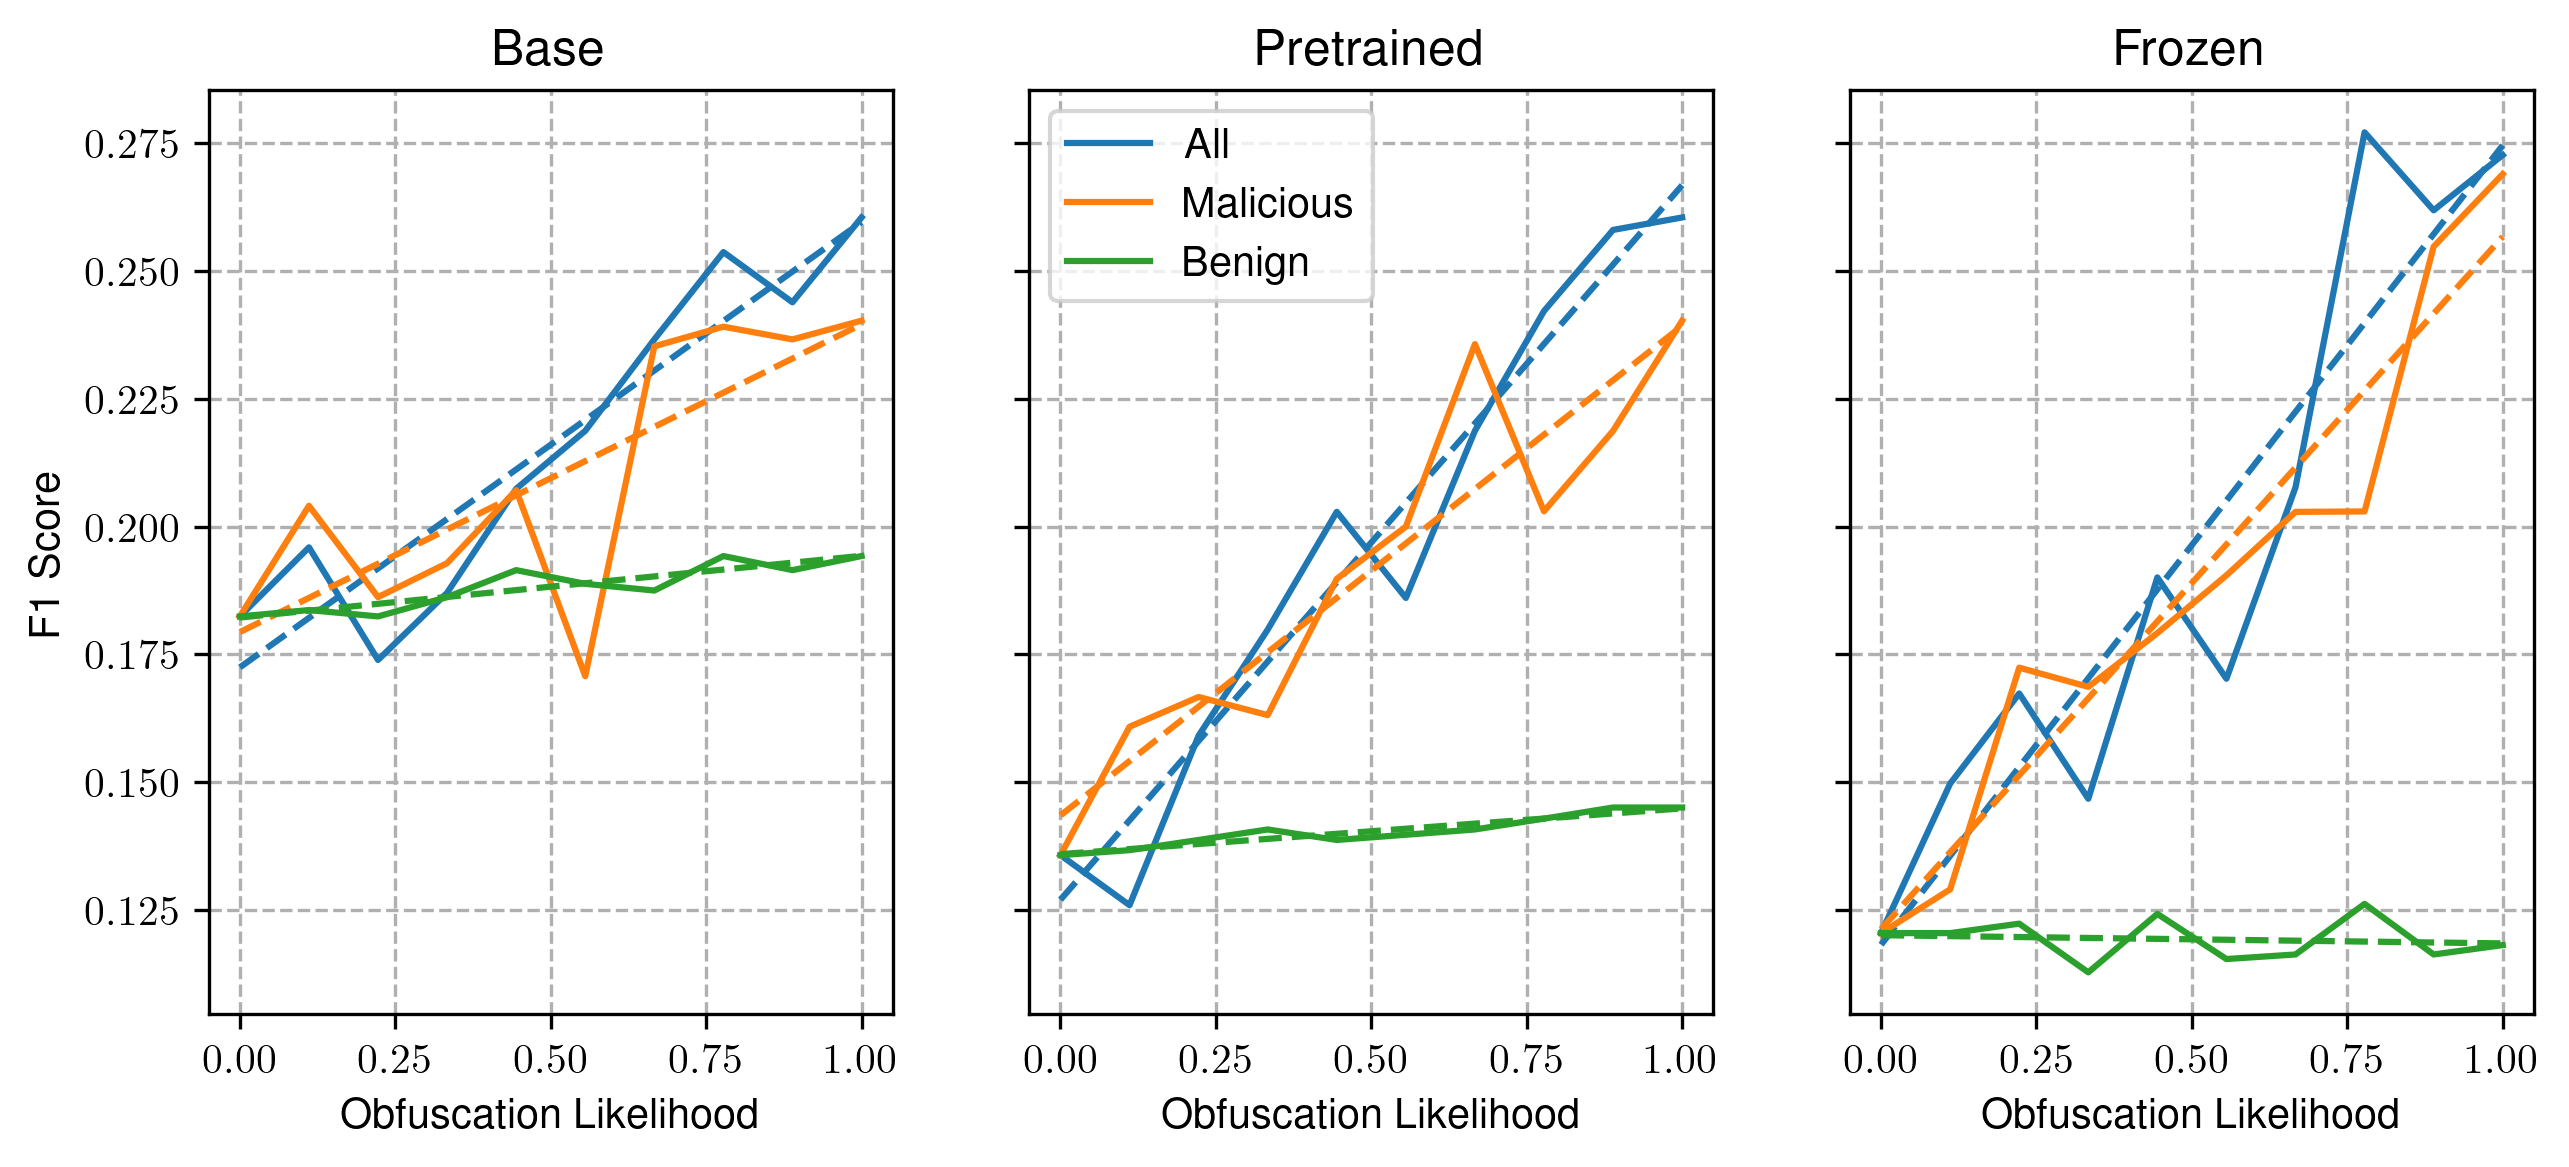

In [6]:
plot_file_level_acc(
    results,
    save_path="/Users/henrywilliams/Documents/uni/masters-thesis/writing/thesis/assets/seq-obf-file-level-base-f1-score.png",
)

## Sequence Level

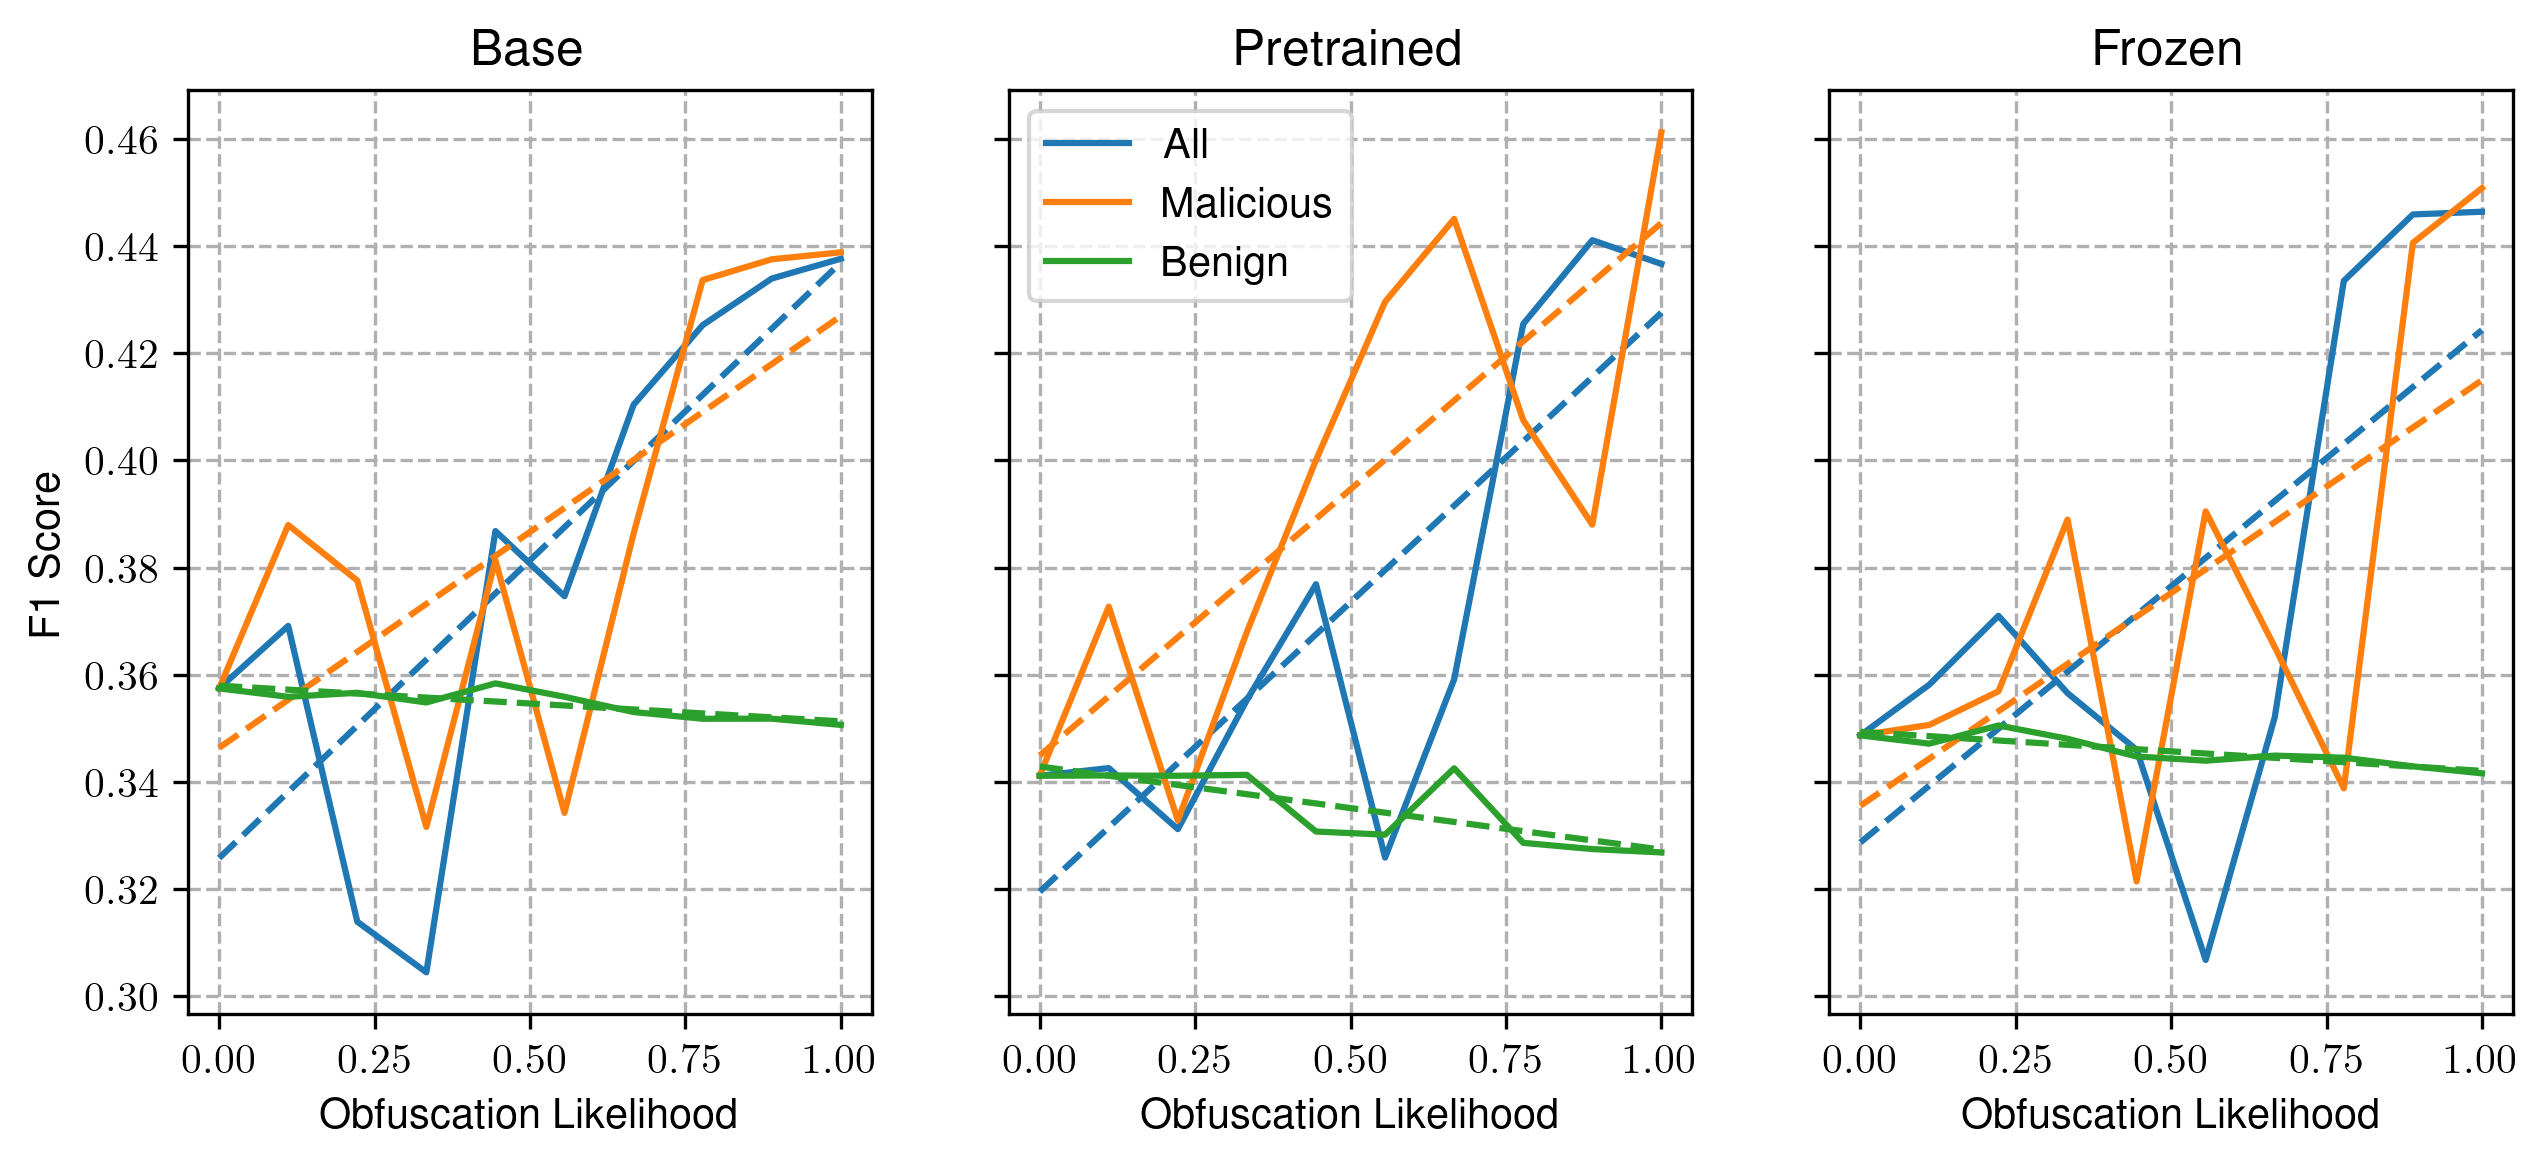

In [7]:
plot_sequence_level_acc(
    results,
    save_path="/Users/henrywilliams/Documents/uni/masters-thesis/writing/thesis/assets/seq-obf-seq-level-base-f1-score.png",
)

## Certainty

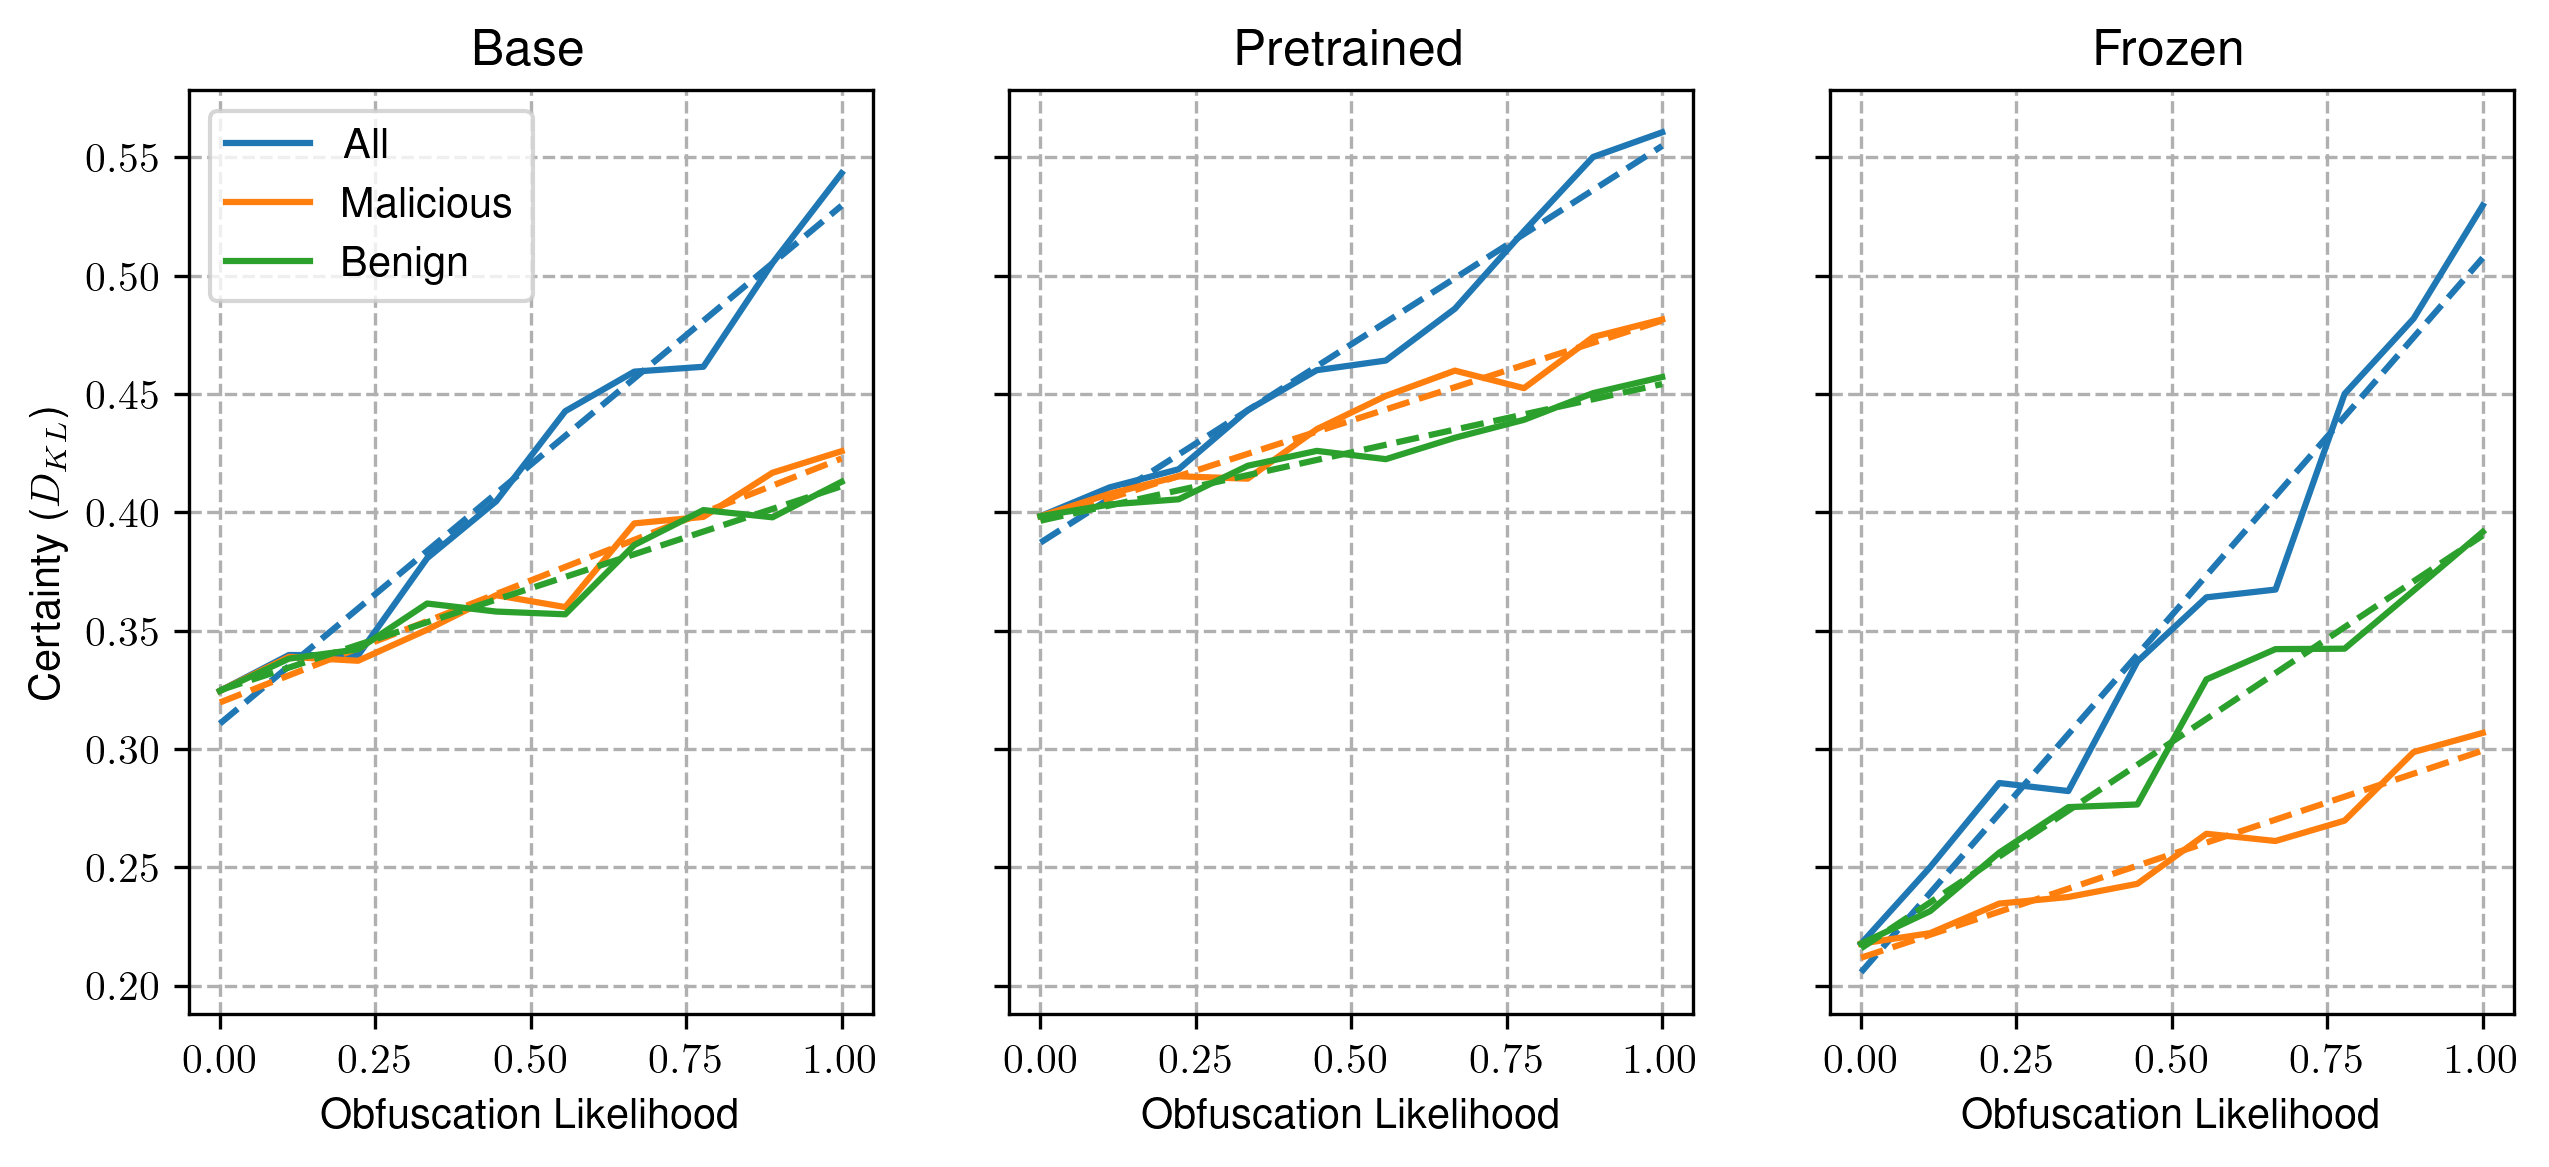

In [8]:
plot_certainty(
    results,
    save_path="/Users/henrywilliams/Documents/uni/masters-thesis/writing/thesis/assets/seq-obf-certainty-base.png",
)

## Prevalence of Obfuscation

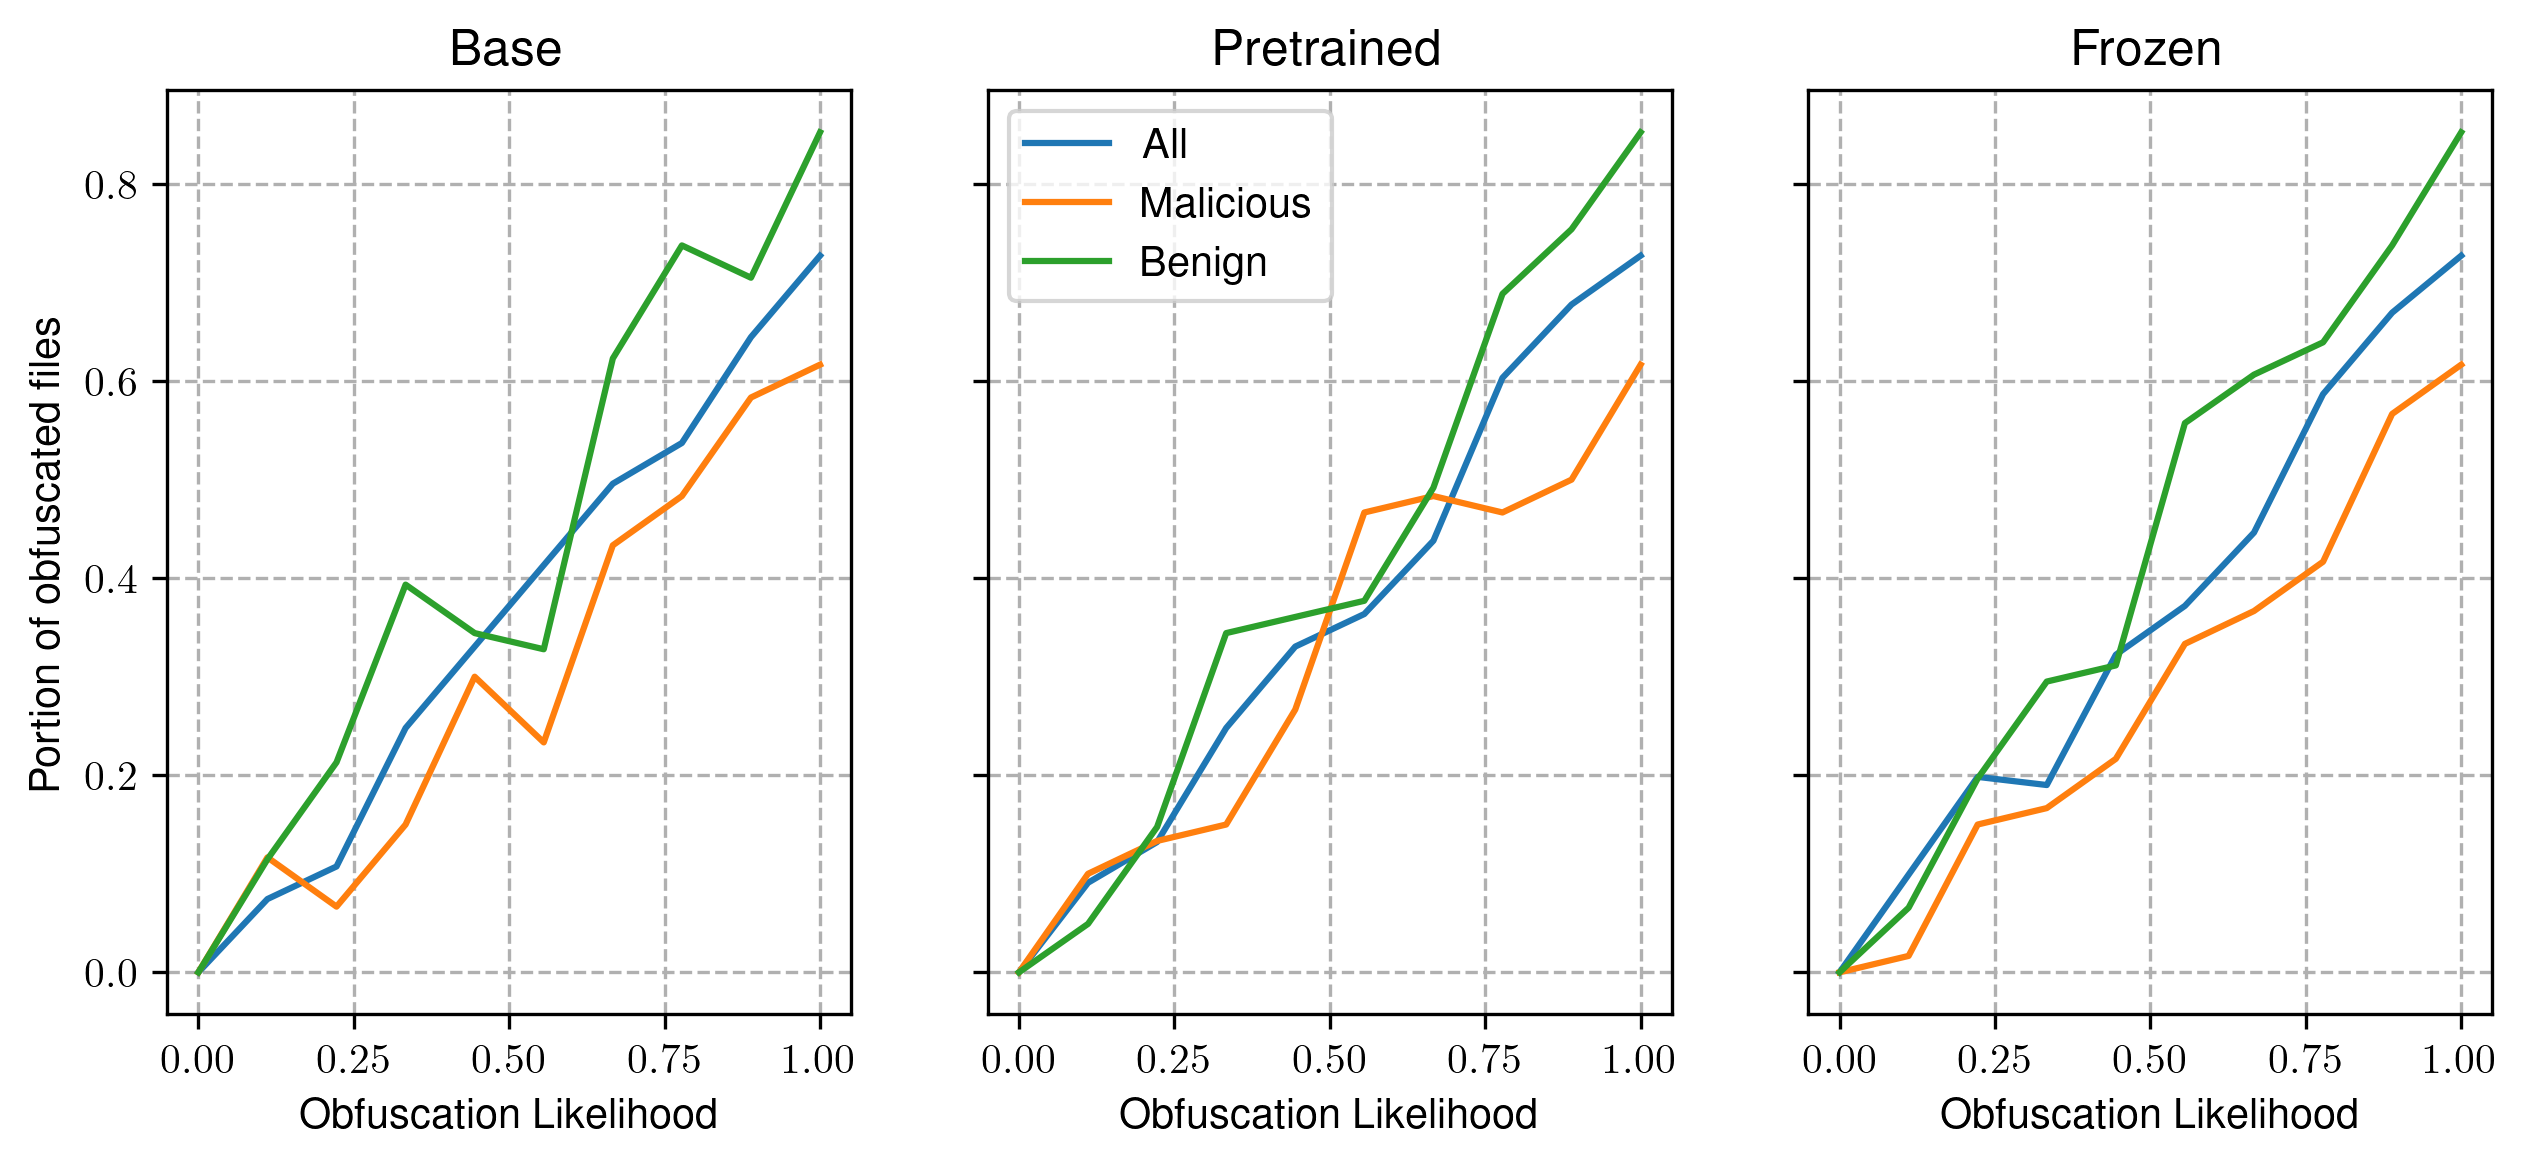

In [9]:
plot_portion_obfuscated(
    results,
    save_path="/Users/henrywilliams/Documents/uni/masters-thesis/writing/thesis/assets/seq-obf-portion-base.png",
)

# Obfuscated Benign 

In [10]:
ob_results = {
    "pretrained": {
        "all": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-ob/pretrained-all",
        "benign": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-ob/pretrained-benign",
        "malicious": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-ob/pretrained-malicious",
    },
    "base": {
        "all": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-ob/base-all",
        "benign": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-ob/base-benign",
        "malicious": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-ob/base-malicious",
    },
    "frozen": {
        "all": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-ob/frozen-all",
        "benign": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-ob/frozen-benign",
        "malicious": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-ob/frozen-malicious",
    },
}

## File level

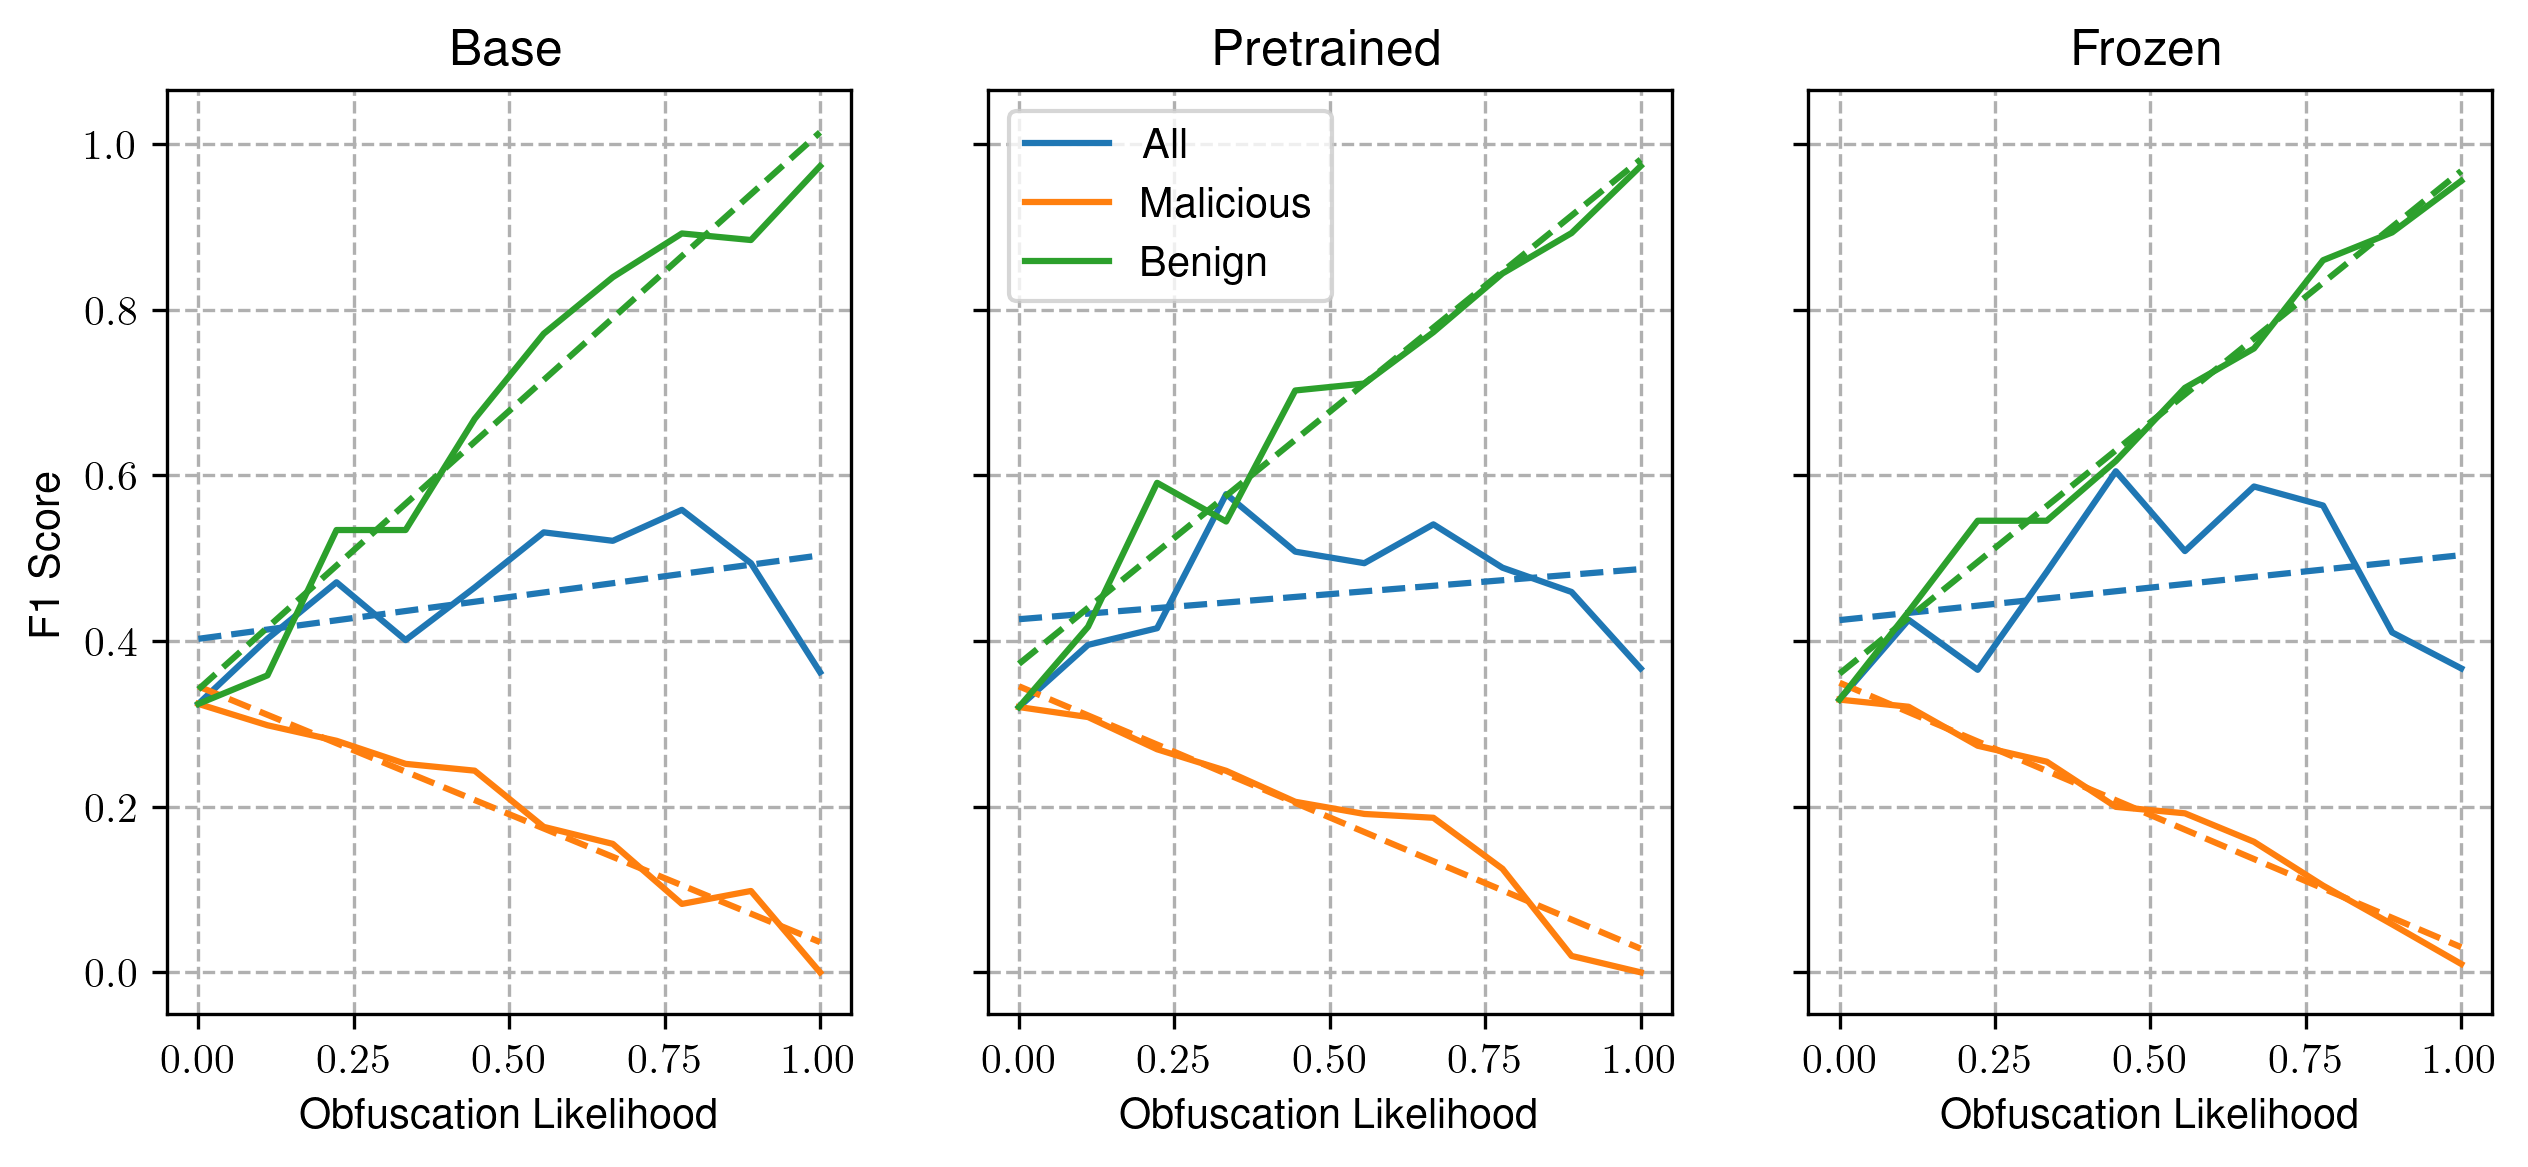

In [11]:
plot_file_level_acc(
    ob_results,
    save_path="/Users/henrywilliams/Documents/uni/masters-thesis/writing/thesis/assets/seq-obf-file-level-ob-f1-score.png",
)

## Sequence Level

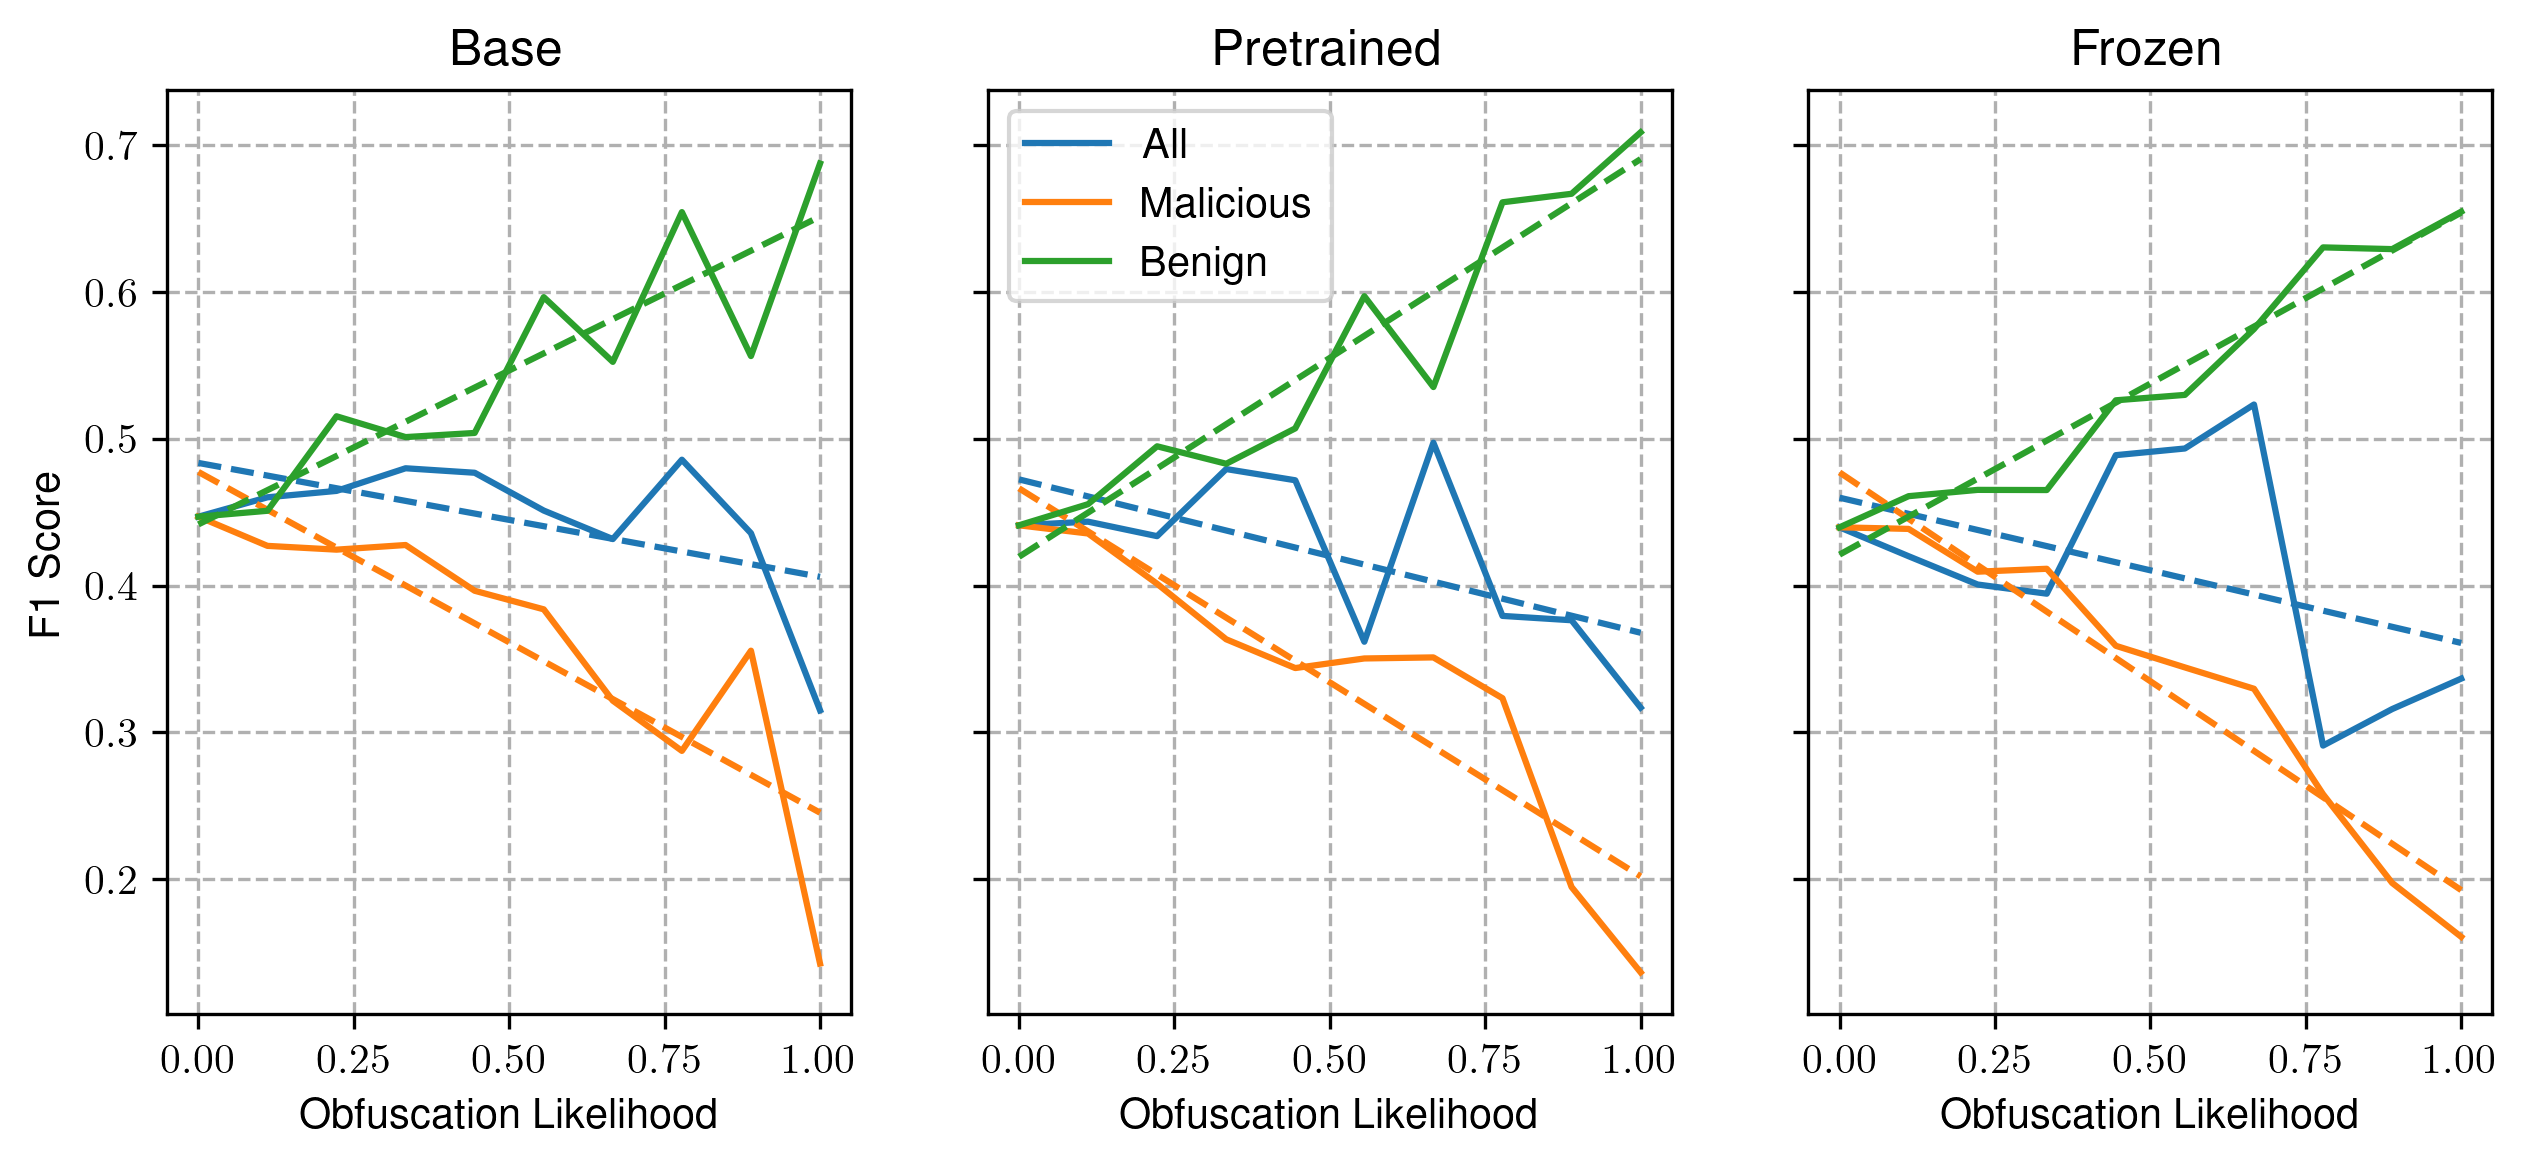

In [12]:
plot_sequence_level_acc(
    ob_results,
    save_path="/Users/henrywilliams/Documents/uni/masters-thesis/writing/thesis/assets/seq-obf-seq-level-ob-f1-score.png",
)

## Certainty

Generating plot...:   0%|          | 0/9 [00:00<?, ?it/s]

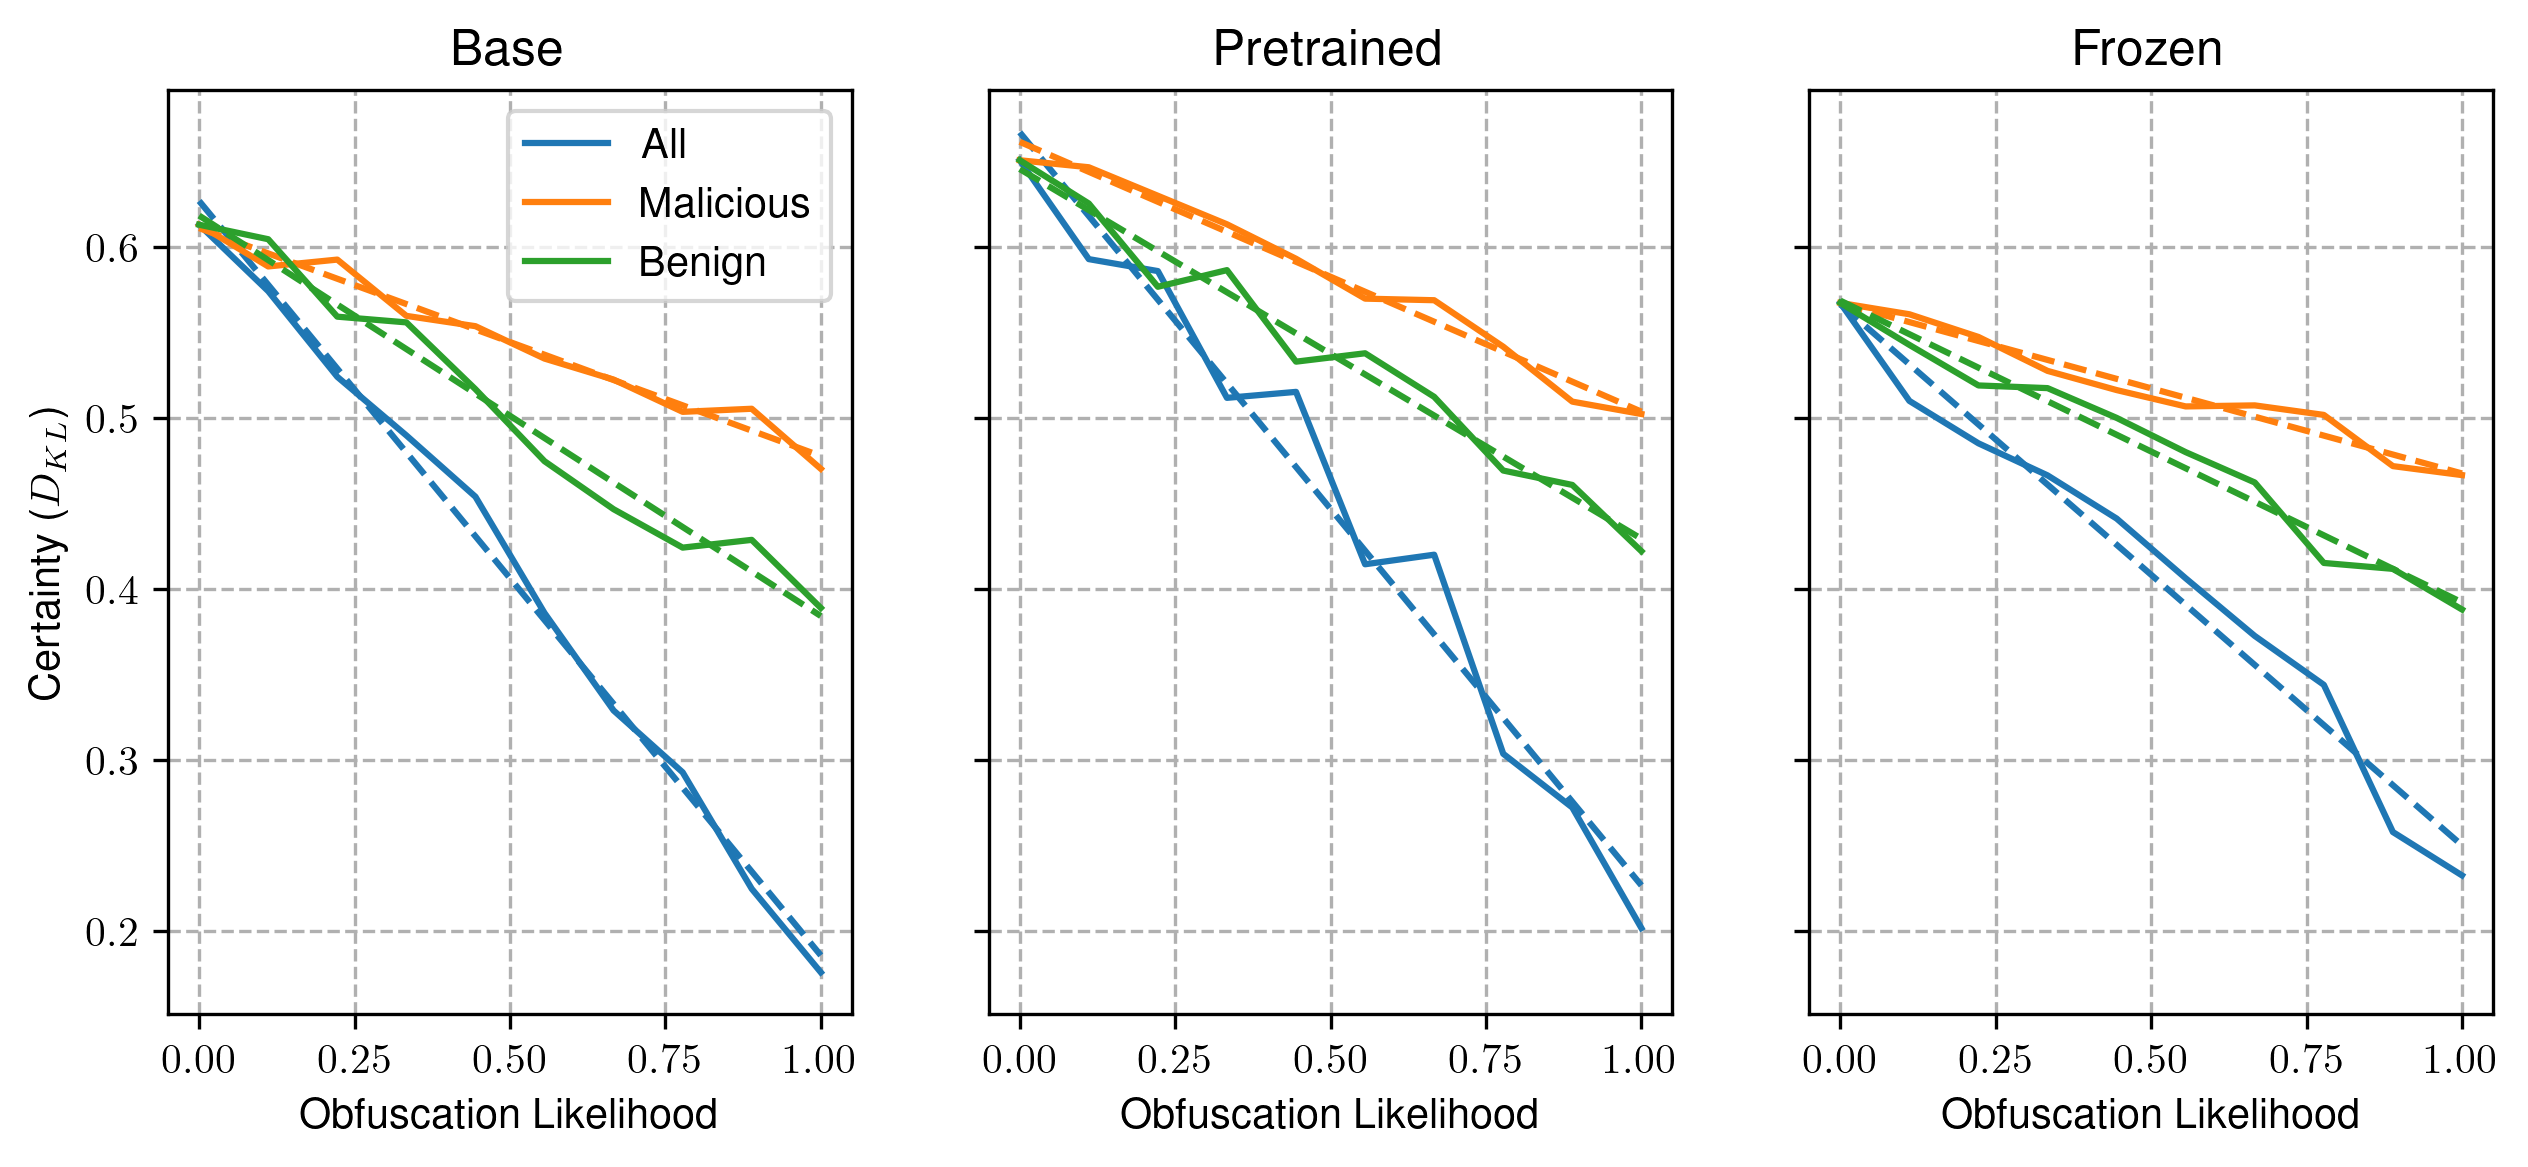

In [13]:
plot_certainty(
    ob_results,
    save_path="/Users/henrywilliams/Documents/uni/masters-thesis/writing/thesis/assets/seq-obf-certainty-ob.png",
)

## Prevalence of Obfuscation

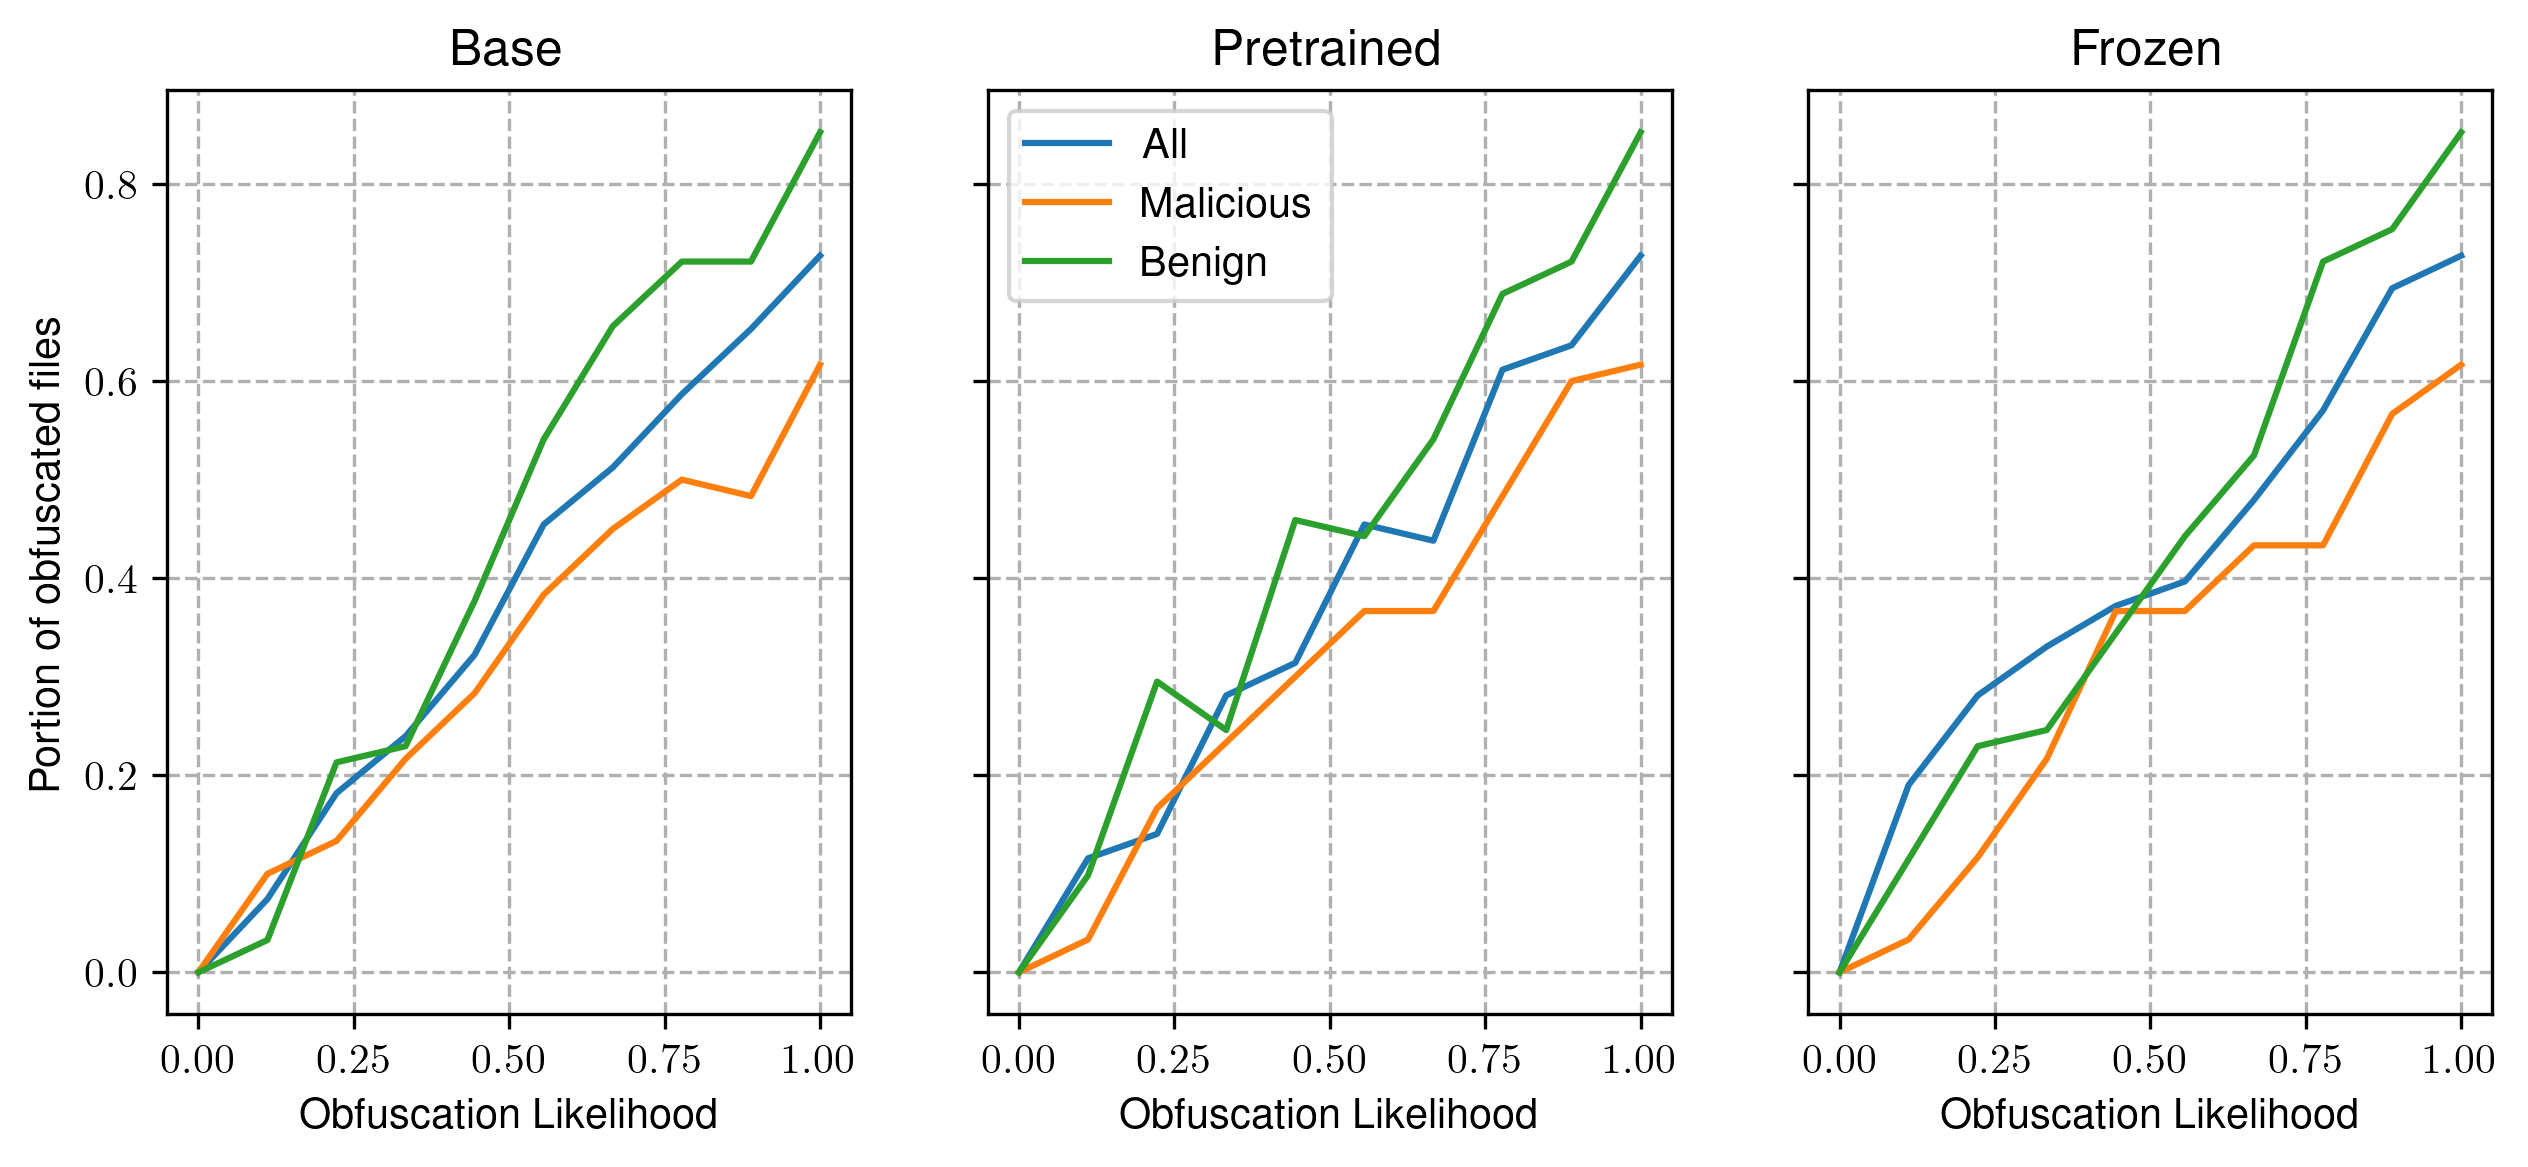

In [14]:
plot_portion_obfuscated(
    ob_results,
    save_path="/Users/henrywilliams/Documents/uni/masters-thesis/writing/thesis/assets/seq-obf-portion-ob.png",
)

# Partially Obfuscated Benign

In [15]:
pob_results = {
    "pretrained": {
        "all": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-pob/pretrained-all",
        "benign": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-pob/pretrained-benign",
        "malicious": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-pob/pretrained-malicious",
    },
    "base": {
        "all": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-pob/base-all",
        "benign": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-pob/base-benign",
        "malicious": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-pob/base-malicious",
    },
    "frozen": {
        "all": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-pob/frozen-all",
        "benign": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-pob/frozen-benign",
        "malicious": "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/obfuscation-experiment-results-with-pob/frozen-malicious",
    },
}

## File Level

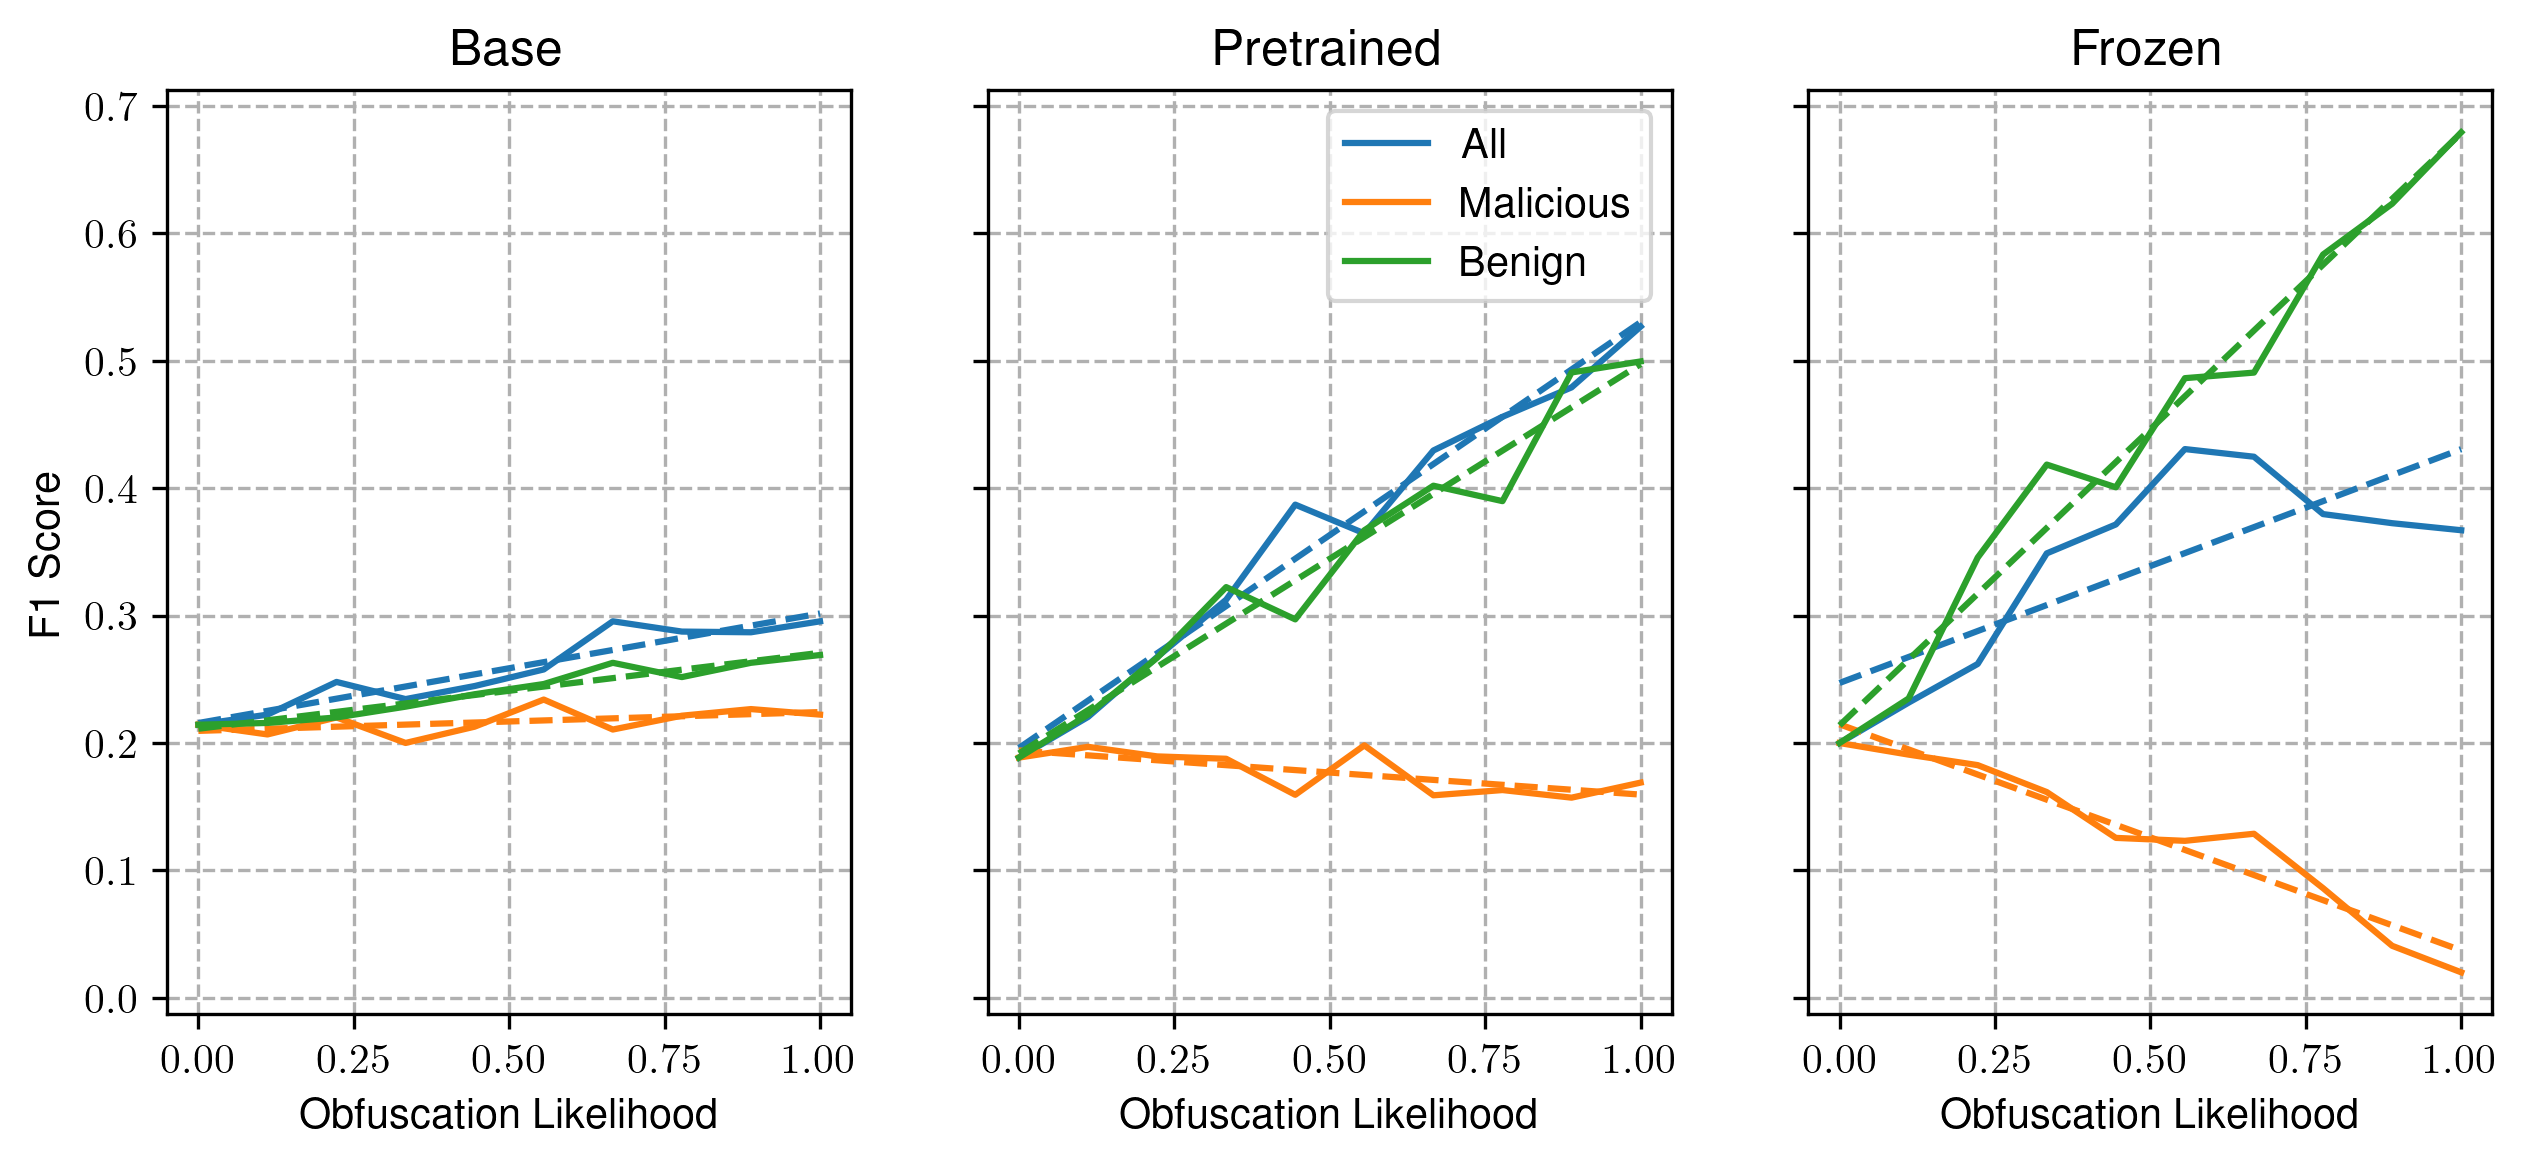

In [16]:
plot_file_level_acc(
    pob_results,
    save_path="/Users/henrywilliams/Documents/uni/masters-thesis/writing/thesis/assets/seq-obf-file-level-pob-f1-score.png",
)

## Sequence Level

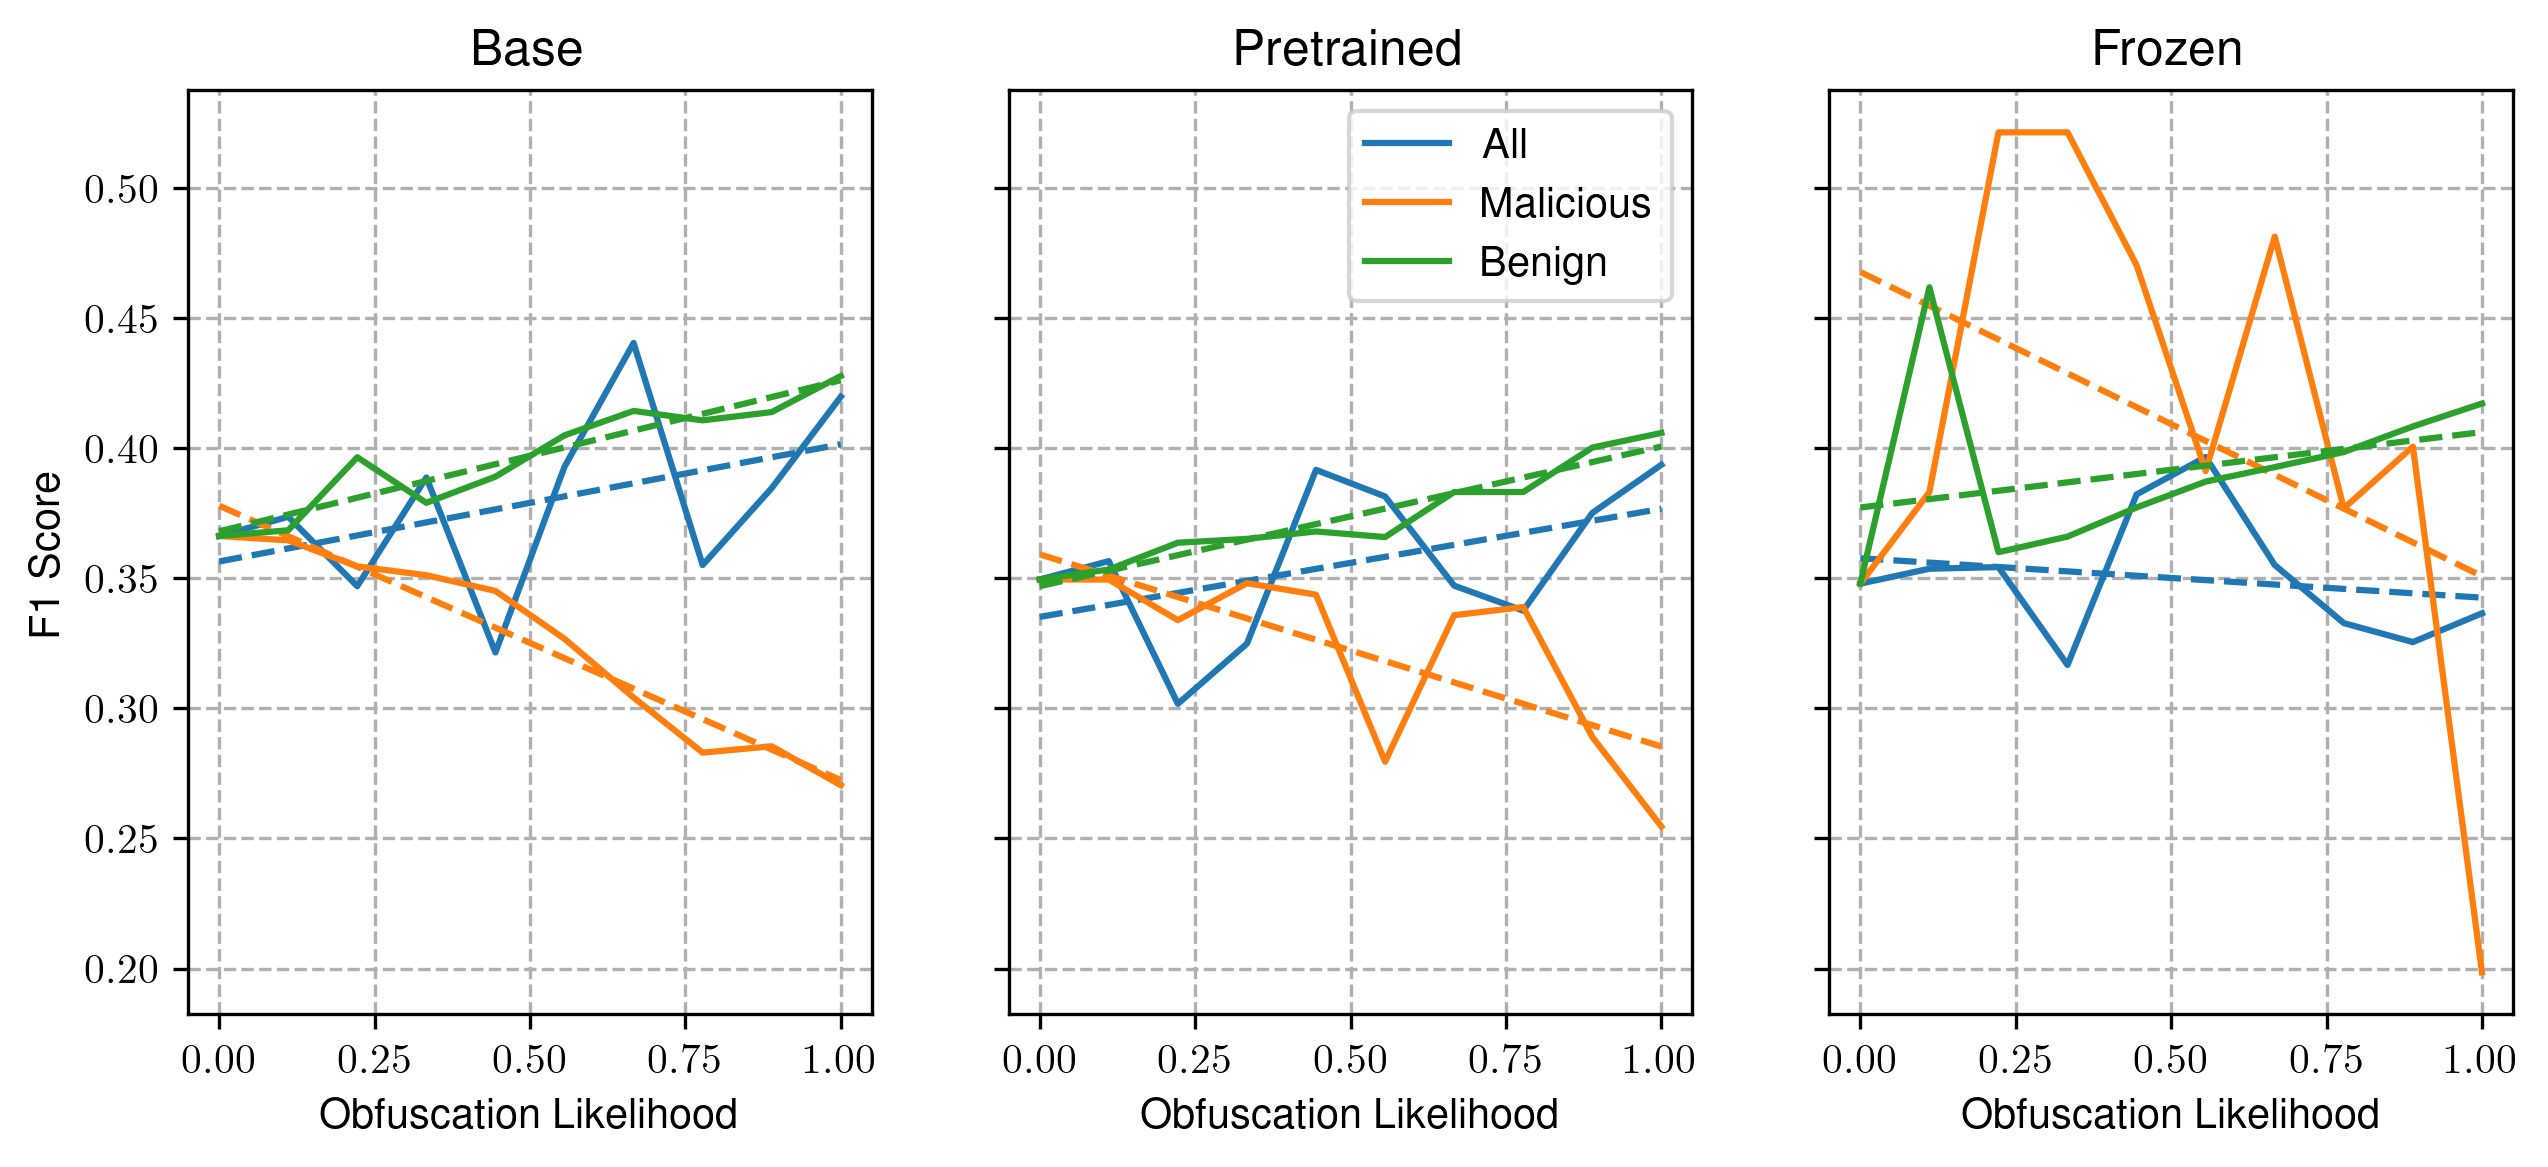

In [17]:
plot_sequence_level_acc(
    pob_results,
    save_path="/Users/henrywilliams/Documents/uni/masters-thesis/writing/thesis/assets/seq-obf-seq-level-pob-f1-score.png",
)

## Certainty

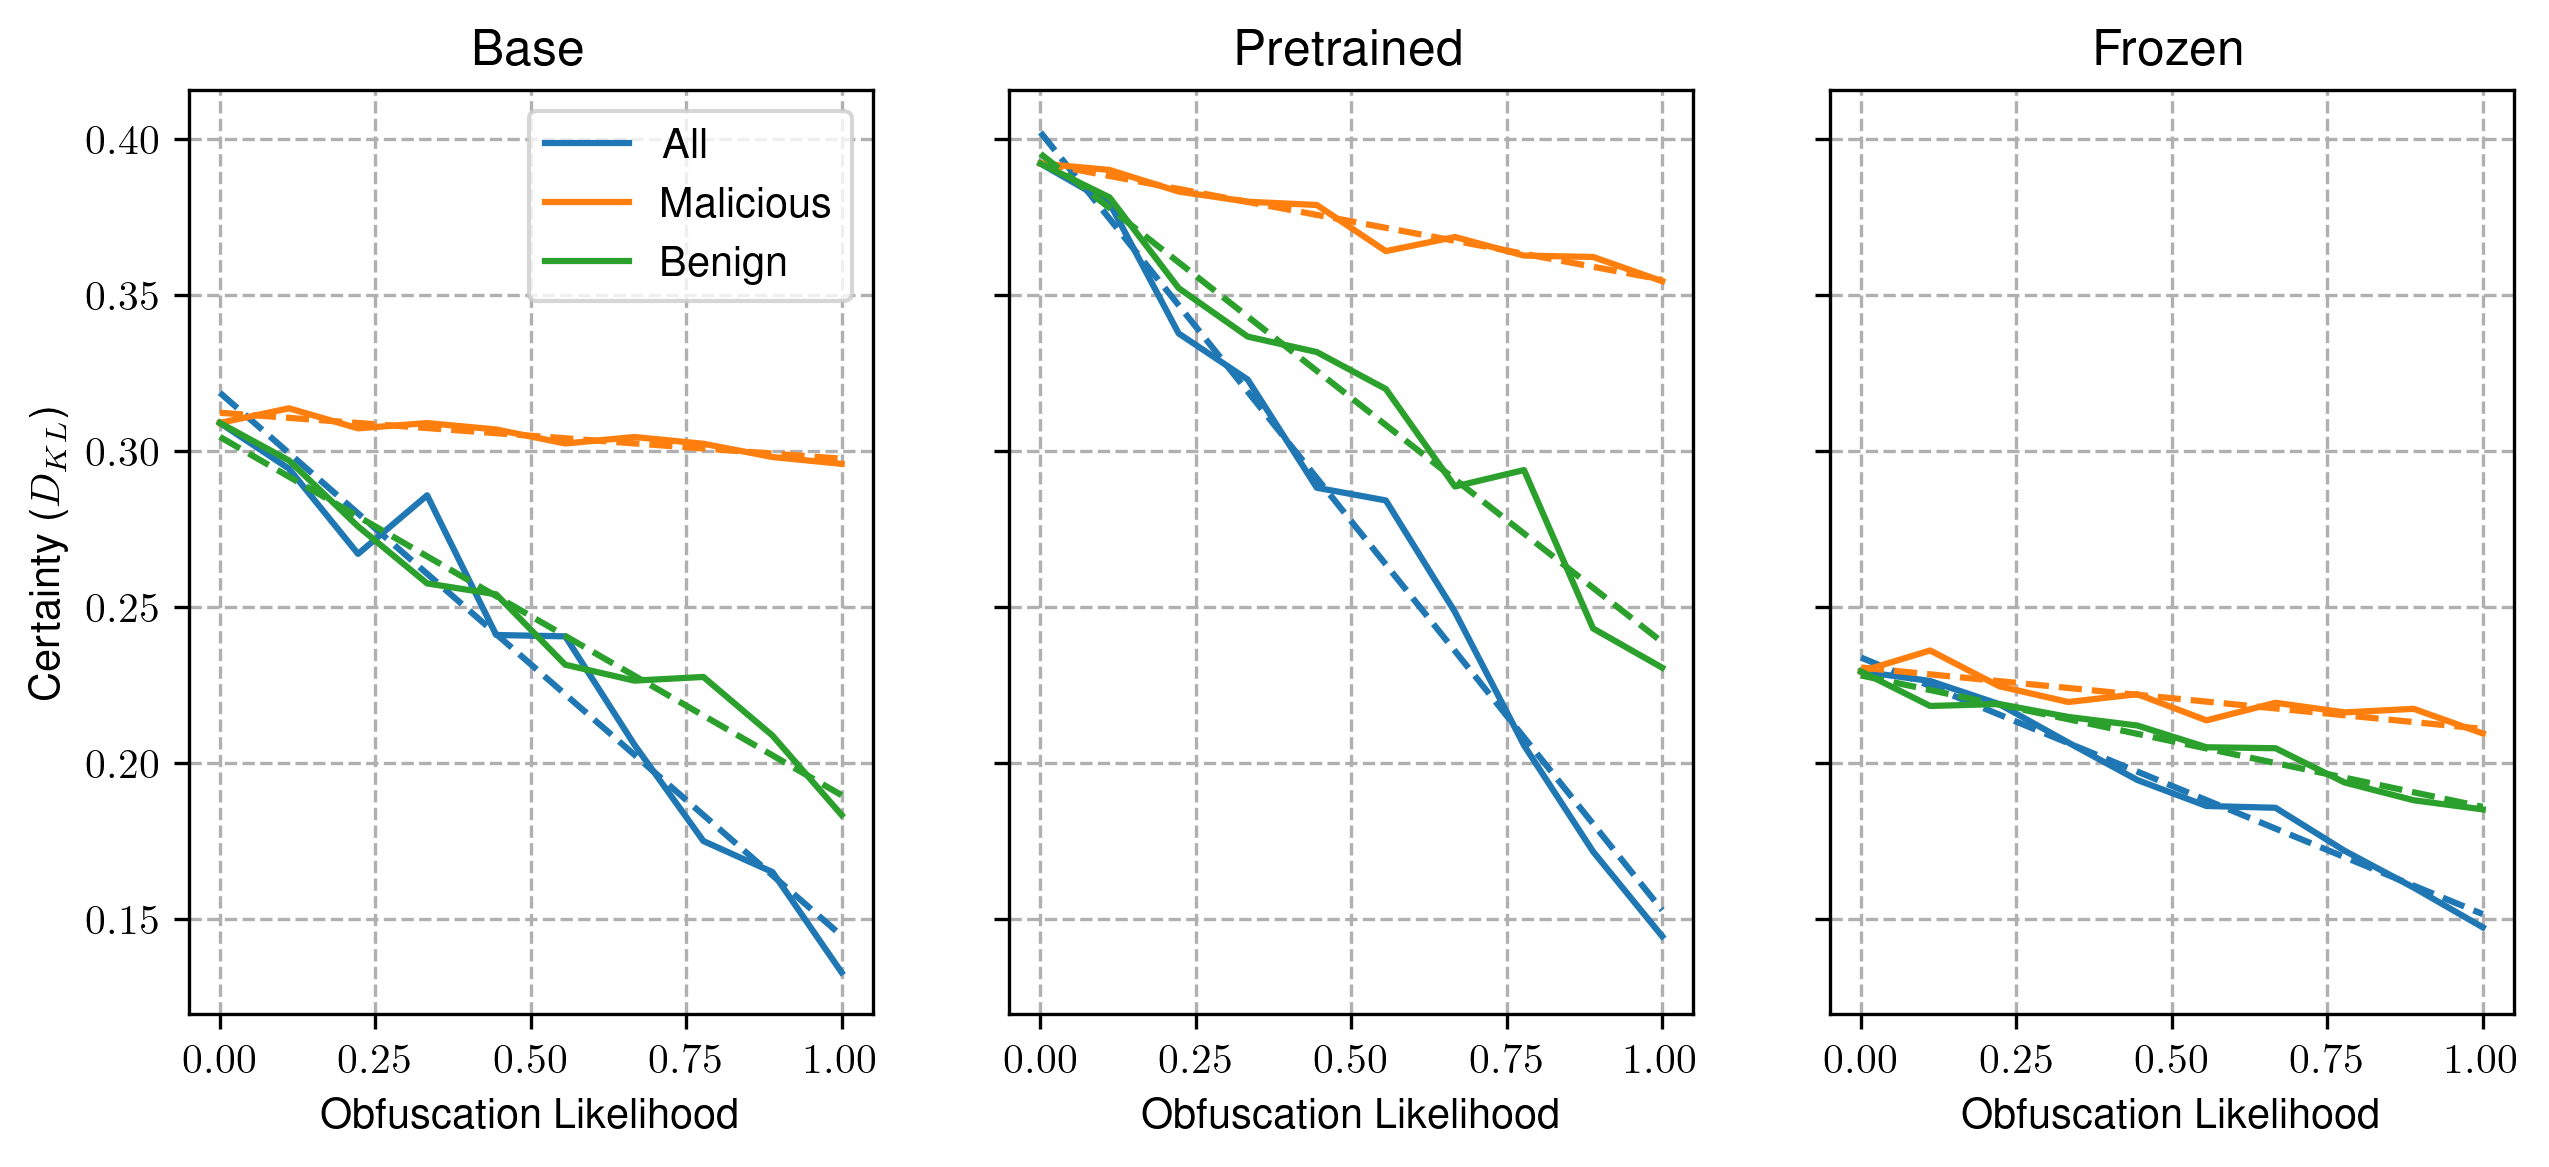

In [18]:
plot_certainty(
    pob_results,
    save_path="/Users/henrywilliams/Documents/uni/masters-thesis/writing/thesis/assets/seq-obf-certainty-pob.png",
)

## Prevalence of Obfuscation

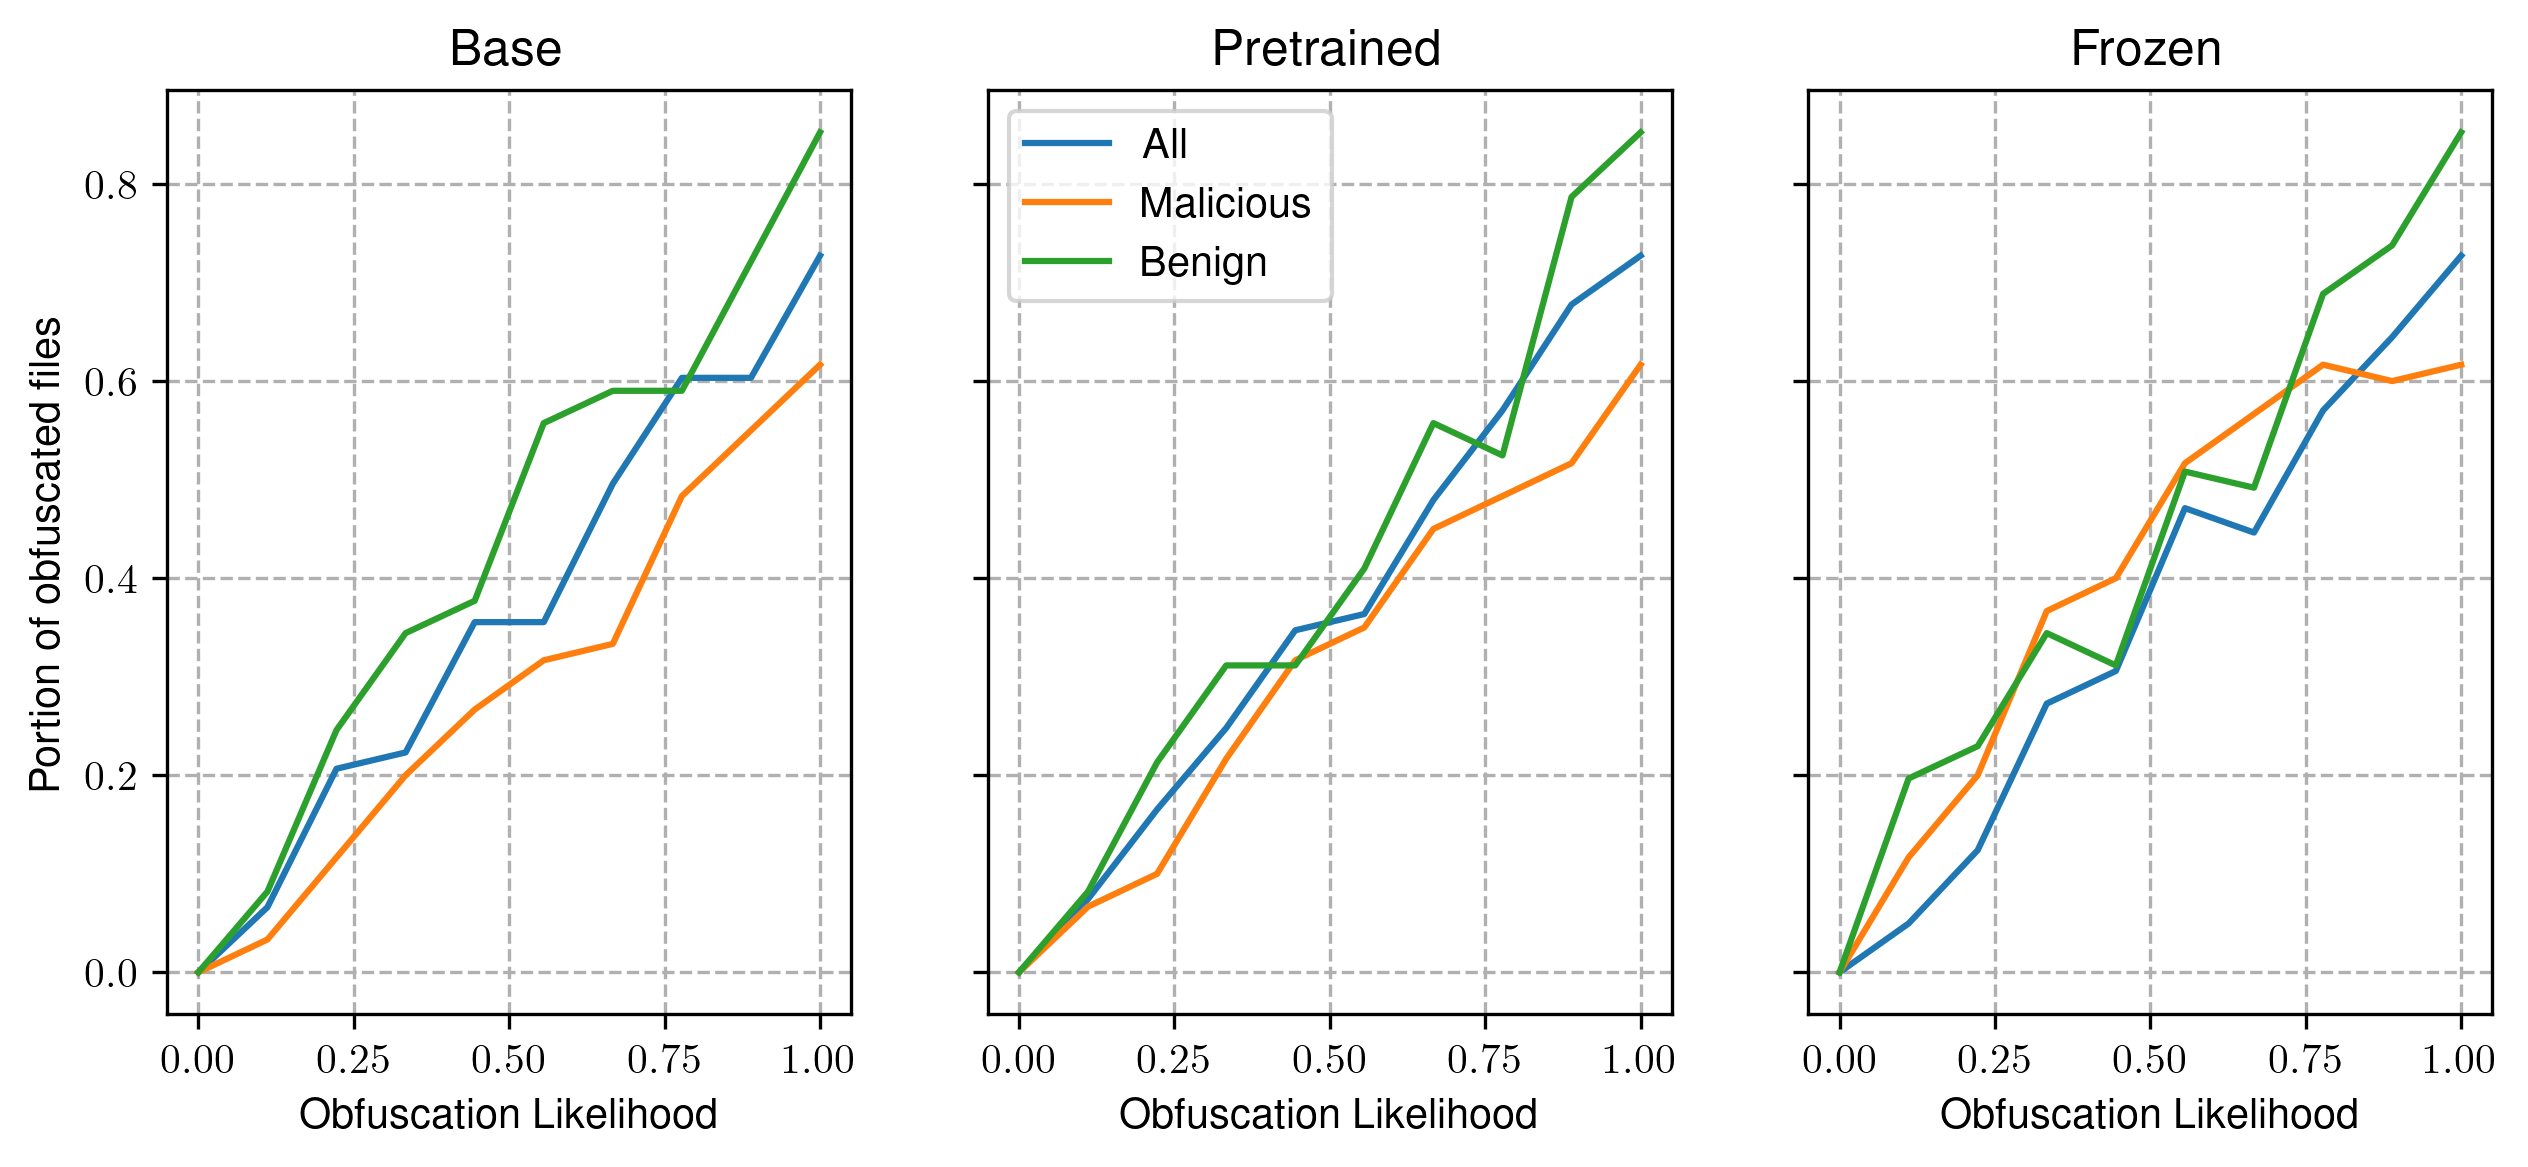

In [19]:
plot_portion_obfuscated(
    pob_results,
    save_path="/Users/henrywilliams/Documents/uni/masters-thesis/writing/thesis/assets/seq-obf-portion-pob.png",
)